### Why scaling up uncertain predictions to higher levels of organisation will underestimate change

<i>Simulations and Figures</i>
    
<b>Authors:</b> <i> James Orr, Jeremy Piggott, Andrew Jackson, Jean-François Arnoldi </i>

<br>

This (`Jupyter`) notebook contains the code for simulations and figures in the paper: "Why scaling up uncertain predictions to higher levels of organisation will underestimate change". It is written in `Python 2.7`.

## Contents <a class="anchor" id="8"></a>
* [Set up](#1)
* [Figure 1](#2)
* [Figure 3](#3)
* [Figure 4](#4)
* [Figure 5](#5)
* [Figure S1](#6)
* [Figure 6](#7)

## Set up <a class="anchor" id="1"></a>
[Top](#8)

In [6]:
# Importing the necessary libraries and packages

import matplotlib.pyplot as plt
import math
from matplotlib import mlab
from matplotlib import rc
from matplotlib import patches
import numpy as np
from numpy.linalg import norm, inv
from scipy.stats import linregress
from scipy.stats import halfnorm
from scipy.stats import binned_statistic
from scipy.stats import cumfreq
from scipy.linalg import eig, expm, solve_lyapunov, svd, det, sqrtm
from scipy import integrate
from scipy.optimize import minimize, newton
from scipy.integrate import odeint
from scipy.special import betainc, erf
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from scipy.spatial.distance import cdist
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap
from matplotlib import gridspec

In [7]:
# Defining functions

def entropy(biomass):
    p = biomass/sum(biomass)
    return np.exp(-sum(p*np.log(p)))

def stability(biomass, sigma):
    return norm(biomass, 1)**2/norm(sigma*biomass, 2)**2

def ipr(biomass, q, p):
    return norm(biomass, q)**q*norm(biomass, p)**p/norm(biomass, p+q)**(p+q)

def gradient(function, x0):
    d = len(x0)
    delta = 0.0000001
    grad = np.zeros(d)
    for n in range(d):
        e_n = np.zeros(d)
        e_n[n] = 1
        grad[n] = (function(x0 + delta*e_n) - function(x0))/delta 
    return grad

def recip(n):
    return 1.0 / n

def eff_d(x, y):
    a = 1/x + 1/y
    return recip(a)

def underestimation(values):
    return len(np.where(values>0.)[0])/(len(values)*1.)

def Q25(x):
    return np.percentile(x, 25, interpolation = 'midpoint')
    
def Q75(x):
    return np.percentile(x, 75, interpolation = 'midpoint')  


<br>
<br>
<br>

## Figure 1 <a class="anchor" id="2"></a>
[Top](#8)

In [8]:
nb = 10000   #Number of perturbations
S=20         #Species richness
N0 = np.exp(np.random.normal(0, 0.05, size = S))    # Initial community with log normal abundance distribution
ent0 = entropy(N0)                                  # Initial shannon diversity index                                                


pop=[]
ent=[]
dist=[]

for n in range(nb):
    eps = np.random.uniform(0.1, 1./2)             # magnitude of predicted change
    r = np.random.uniform(0, .7)                   # magnitude of uncertainty 
    u = np.random.normal(0, 1, size=S)
    u = u/norm(u, 2)                               # random unit vector (direction of error)
    v = np.random.normal(0, 1, size=S)
    v = v/norm(v, 2)                               # random unit vector (direction of prediction)
    N_exp = np.maximum(N0*(1+v*eps),np.zeros(S))             # Prediction 
    N_true=np.maximum(N0+N0*eps*(v+r*u) ,np.zeros(S))        # Realisation 
    ent_exp = entropy(N_exp)                                 # Predicted entropy 
    ent_true = entropy(N_true)                               # Realized entropy
    
    #understimation of change at population level:
    
    pop=np.concatenate([pop,[abs(N_true[0]-N0[0])/abs(N_exp[0]-N0[0])-1]]) 
    
    #understimation of change at community-level, defined as:

    dist=np.concatenate([dist,[norm(N_true-N0)/norm(N_exp-N0)-1]])     # Euclidian distance
    ent=np.concatenate([ent,[abs(ent_true-ent0)/abs(ent_exp-ent0)-1]]) # Shannon diversity index (entropy)




Pent= 0.7254
Pdist= 0.7637
Ppop= 0.552


(0, 3)

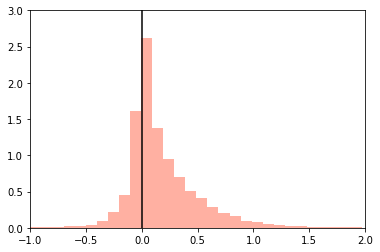

In [9]:
#Draw histograms:

Pent=len(ent[ent>0])/(1.*nb) #proba of understimation of change measured as shannon diversity index
print 'Pent=',  Pent
Pdist=len(dist[dist>0])/(1.*nb) #proba of understimation of change measured as euclidian distance
print 'Pdist=', Pdist
Ppop=len(pop[pop>0])/(1.*nb) #proba of understimation of change at population level
print 'Ppop=', Ppop

#plt.hist(pop[pop<2],bins=30,density=1,alpha=0.5)
plt.hist(ent[ent<2],bins=30,density=1,alpha=0.5,color='tomato')
#plt.hist(dist[dist<2],bins=30,density=1,alpha=0.5,color='tomato')
plt.axvline(0,ls='-',color='k')
#plt.axes().set_aspect('equal')
plt.xlim(-1,2)
plt.ylim(0,3)

<br>
<br>
<br>

## Figure 3 <a class="anchor" id="3"></a>
[Top](#8)

In [22]:
nb=20000                                        # number of 'experiments'


################## 1-D (line) #####################

S=1 
Non_add_1=np.random.uniform(0, 2, size = nb)   # drawing the magnitude of uncertainty for each 'experiment'
Effect_1=np.zeros(nb)                          # defining the effect vector (made up of zeros of nb length)
for n in range(nb):
    Add_1 = np.random.normal(0, 1, size=S)     # random unit vector (direction of prediction)
    Add_1 = Add_1/norm(Add_1)                  # normalized 
    u_1=np.random.normal(0,1,size=S)           # random unit vector (direction of error)
    u_1=u_1/norm(u_1)                          # normalized
    u_1=Non_add_1[n]*u_1                       # uncertainty
    Effect_1[n]=norm(Add_1+u_1)-1.             # the true effect = prediction + error

Prob_Syn_1 = 1.-0.5*betainc((S-1.)/2., 0.5, 1.-(Non_add_1**2)/4) # probability of underestimation 

########### Binning ############
bin_1_y, bin_edges, binnumber = binned_statistic(Non_add_1, Effect_1, statistic="median", bins=6, range=(0, 1.0)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_1_x = bin_edges[1:] - bin_width/2
#bin_1_y_sd, bin_edges, binnumber = binned_statistic(Non_add_1, Effect_1, statistic="std", bins=6, range=(0, 1.0)) 


################## 2-D (circle) #####################

S=2 
Non_add_2=np.random.uniform(0, 2, size = nb)  
Effect_2=np.zeros(nb)
for n in range(nb):
    Add_2 = np.random.normal(0, 1, size=S)       
    Add_2 = Add_2/norm(Add_2)                        
    u_2=np.random.normal(0,1,size=S)             
    u_2=u_2/norm(u_2)
    u_2=Non_add_2[n]*u_2                         
    Effect_2[n]=norm(Add_2+u_2)-1.

Prob_Syn_2 = 1.-0.5*betainc((S-1.)/2., 0.5, 1.-(Non_add_2**2)/4) 

########### Binning ############
bin_2_y, bin_edges, binnumber = binned_statistic(Non_add_2, Effect_2, statistic="median", bins=7, range=(0, 1.2)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_2_x = bin_edges[1:] - bin_width/2
#bin_2_y_sd, bin_edges, binnumber = binned_statistic(Non_add_2, Effect_2, statistic="std", bins=6, range=(0, 1.0)) 
bin_2_y_q25, bin_edges, binnumber = binned_statistic(Non_add_2, Effect_2, statistic=Q25, bins=7, range=(0, 1.2)) 
bin_2_y_q75, bin_edges, binnumber = binned_statistic(Non_add_2, Effect_2, statistic=Q75, bins=7, range=(0, 1.2)) 




################## 10-D (hyper-sphere) #####################

S=10 
Non_add_10=np.random.uniform(0, 2, size = nb)  
Effect_10=np.zeros(nb)
for n in range(nb):
    Add_10 = np.random.normal(0, 1, size=S)      
    Add_10 = Add_10/norm(Add_10)                      
    u_10=np.random.normal(0,1,size=S)             
    u_10=u_10/norm(u_10)
    u_10=Non_add_10[n]*u_10                          
    Effect_10[n]=norm(Add_10+u_10)-1.

Prob_Syn_10 = 1.-0.5*betainc((S-1.)/2., 0.5, 1.-(Non_add_10**2)/4) 

########### Binning ############
bin_10_y, bin_edges, binnumber = binned_statistic(Non_add_10, Effect_10, statistic="median", bins=7, range=(0, 1.2)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_10_x = bin_edges[1:] - bin_width/2
#bin_10_y_sd, bin_edges, binnumber = binned_statistic(Non_add_10, Effect_10, statistic="std", bins=6, range=(0, 1.0)) 
bin_10_y_q25, bin_edges, binnumber = binned_statistic(Non_add_10, Effect_10, statistic=Q25, bins=7, range=(0, 1.2)) 
bin_10_y_q75, bin_edges, binnumber = binned_statistic(Non_add_10, Effect_10, statistic=Q75, bins=7, range=(0, 1.2)) 



################## 20-D (hyper-sphere) #####################

S=20 
Non_add_20=np.random.uniform(0, 2, size = nb)  
Effect_20=np.zeros(nb)
for n in range(nb):
    Add_20 = np.random.normal(0, 1, size=S)      
    Add_20 = Add_20/norm(Add_20)                    
    u_20=np.random.normal(0,1,size=S)             
    u_20=u_20/norm(u_20)
    u_20=Non_add_20[n]*u_20                          
    Effect_20[n]=norm(Add_20+u_20)-1.

Prob_Syn_20 = 1.-0.5*betainc((S-1.)/2., 0.5, 1.-(Non_add_20**2)/4) 

########### Binning ############
bin_20_y, bin_edges, binnumber = binned_statistic(Non_add_20, Effect_20, statistic="median", bins=7, range=(0, 1.2)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_20_x = bin_edges[1:] - bin_width/2
#bin_20_y_sd, bin_edges, binnumber = binned_statistic(Non_add_20, Effect_20, statistic="std", bins=6, range=(0, 1.0)) 
bin_20_y_q25, bin_edges, binnumber = binned_statistic(Non_add_20, Effect_20, statistic=Q25, bins=7, range=(0, 1.2)) 
bin_20_y_q75, bin_edges, binnumber = binned_statistic(Non_add_20, Effect_20, statistic=Q75, bins=7, range=(0, 1.2)) 





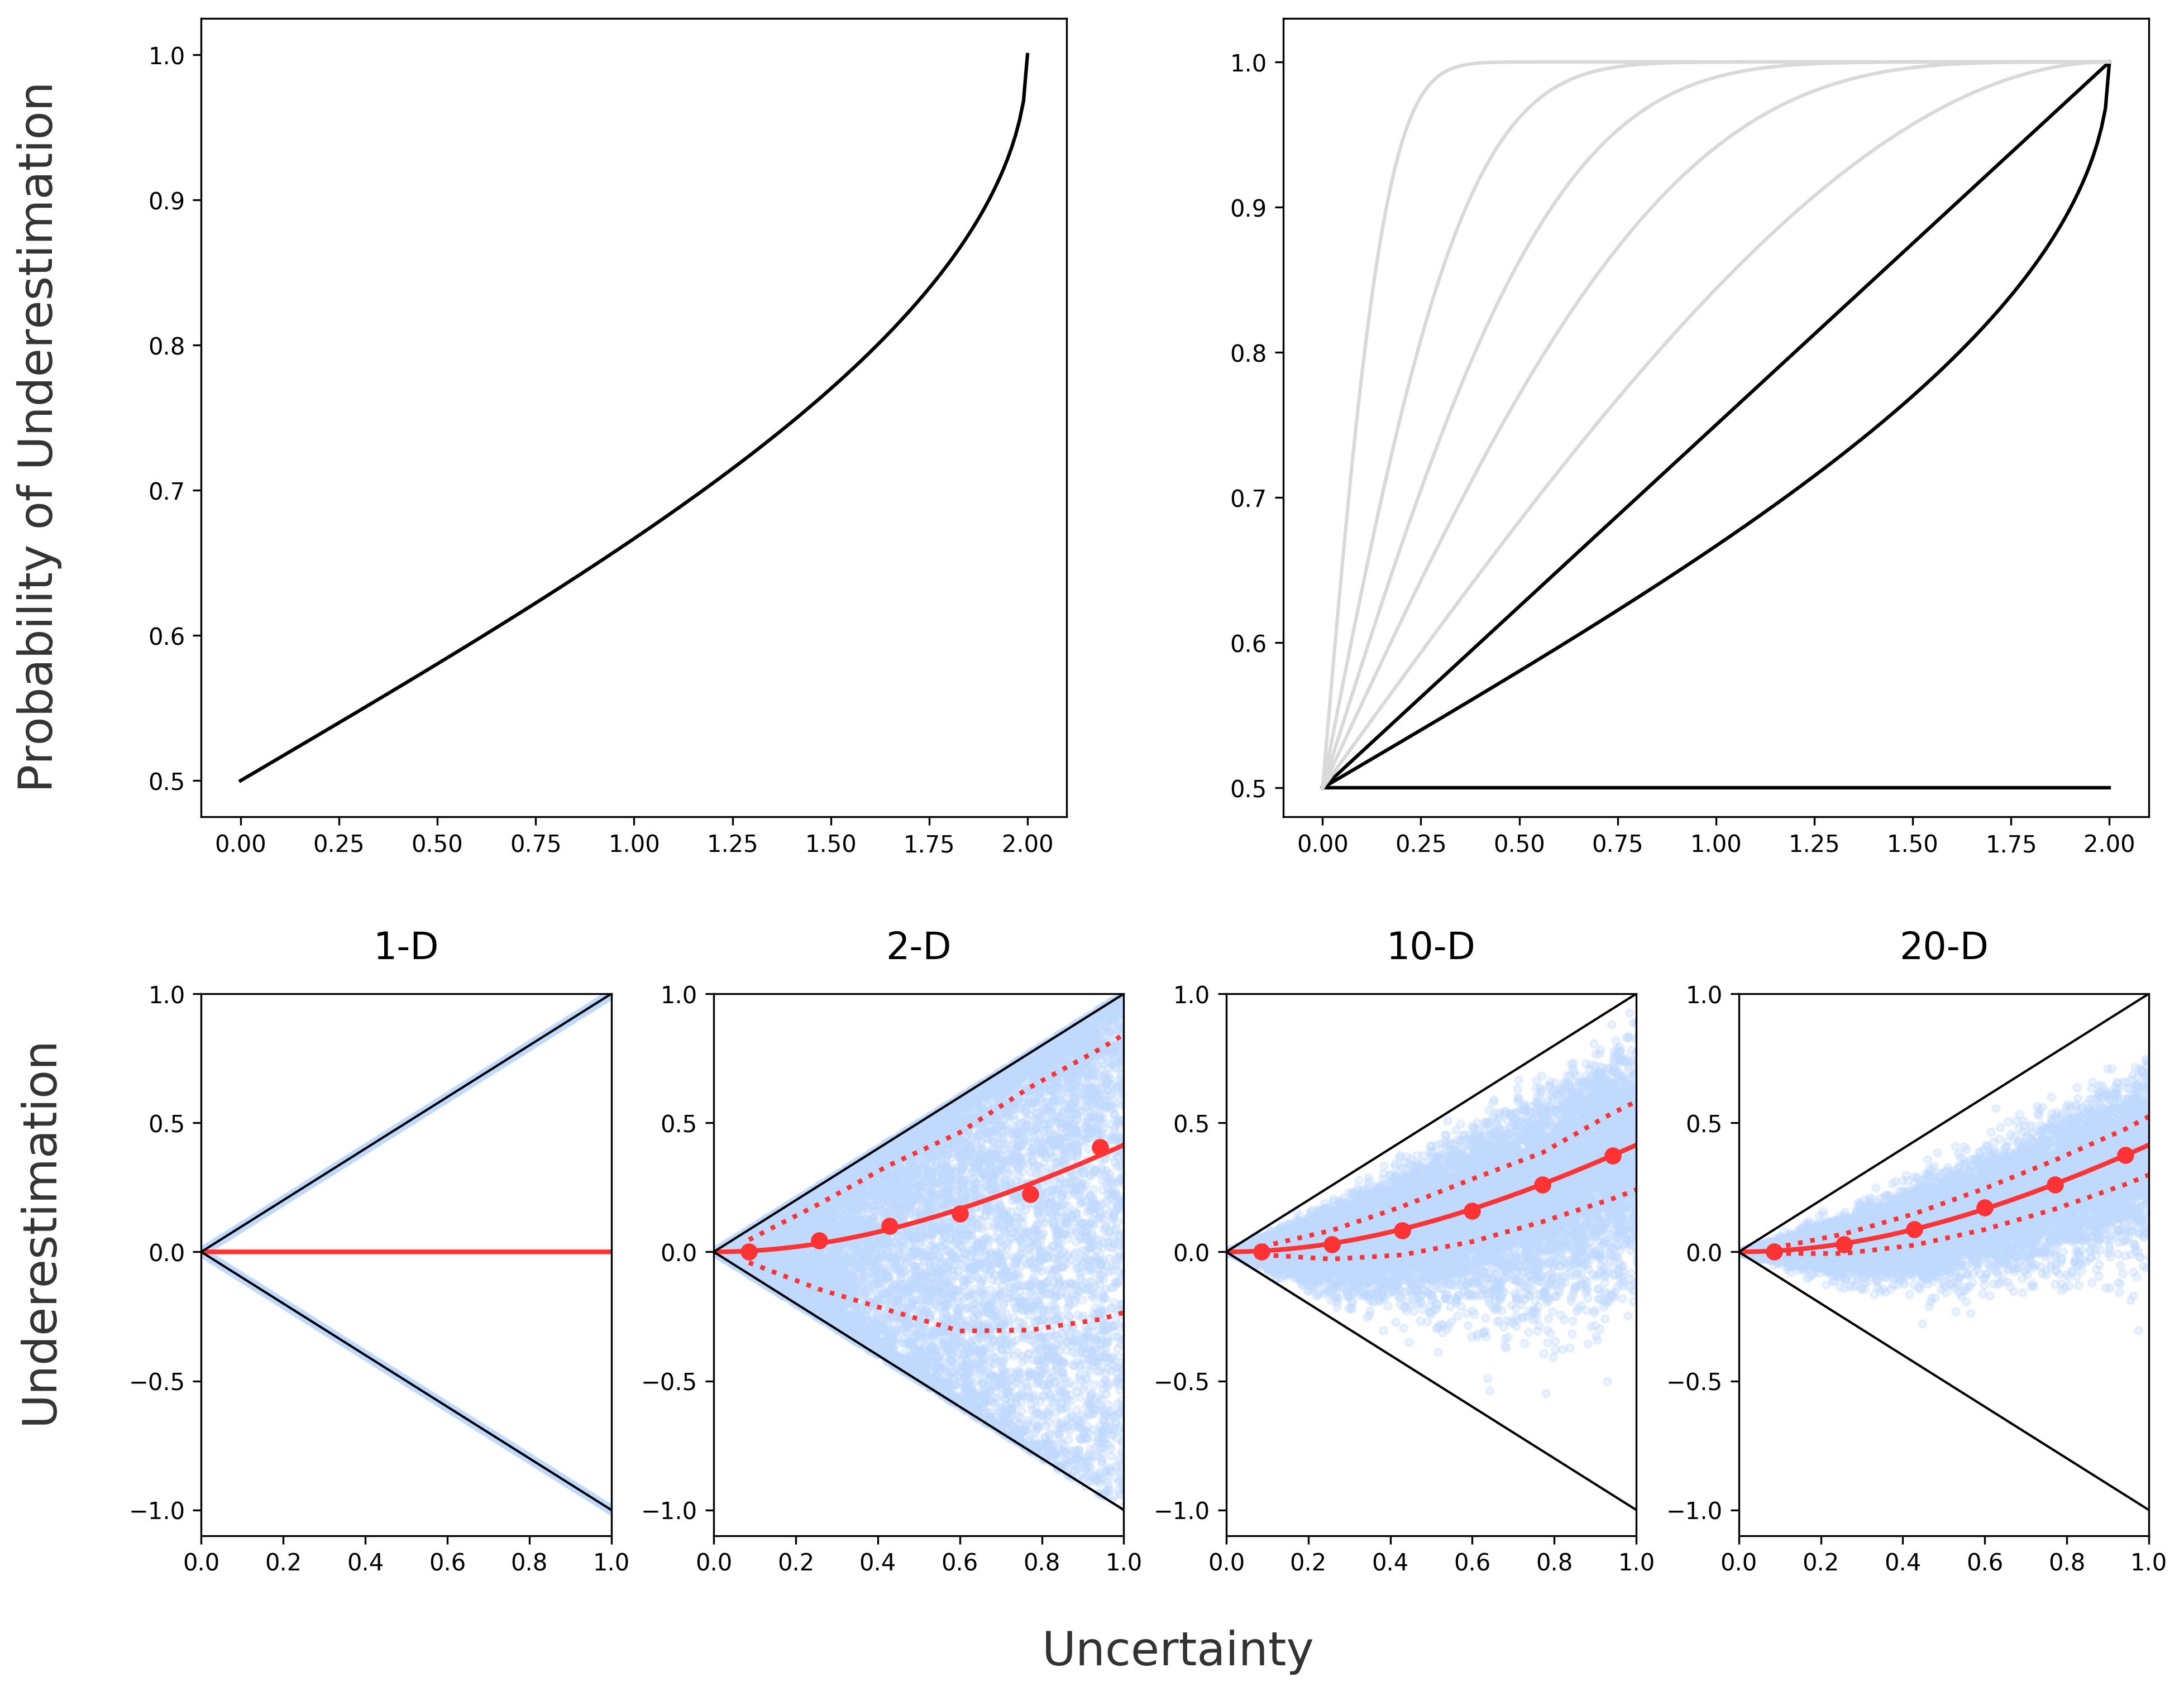

In [23]:
plt.figure(num=None, figsize=(15, 12), dpi=300, facecolor='w', edgecolor='k')


############ Figure 3(a) #################

plt.subplot(2, 2, 1) 
X = np.linspace(0, 2, 200)
plt.plot(X, 1.-0.5*betainc((2-1.)/2., 0.5, 1.-(X**2)/4), color=(0, 0, 0))


############ Figure 3(b) #################

plt.subplot(2, 2, 2) 
X = np.linspace(0, 2, 200)
plt.plot([0, 2], [0.50, 0.50], color=(0, 0, 0), label="1")
plt.plot(X, 1.-0.5*betainc((2-1.)/2., 0.5, 1.-(X**2)/4), color=(0, 0, 0), label="2")
plt.plot(X, 1.-0.5*betainc((3-1.)/2., 0.5, 1.-(X**2)/4), color=(0, 0, 0), label="3")

plt.plot(X, 1.-0.5*betainc((5-1.)/2., 0.5, 1.-(X**2)/4), color=(0.85, 0.85, 0.85), label="5")
plt.plot(X, 1.-0.5*betainc((10-1.)/2., 0.5, 1.-(X**2)/4), color=(0.85, 0.85, 0.85), label="10")
plt.plot(X, 1.-0.5*betainc((20-1.)/2., 0.5, 1.-(X**2)/4), color=(0.85, 0.85, 0.85), label="20")
plt.plot(X, 1.-0.5*betainc((50-1.)/2., 0.5, 1.-(X**2)/4), color=(0.85, 0.85, 0.85), label="50")
plt.plot(X, 1.-0.5*betainc((250-1.)/2., 0.5, 1.-(X**2)/4), color=(0.85, 0.85, 0.85), label="250")

plt.xlim(-0.1, 2.1)
plt.ylim(0.48, 1.03)



############ Figure 3(c) #################

##### 1-D #####
plt.subplot(3, 4, 9) 
plt.scatter(Non_add_1, Effect_1, alpha = 0.3, color = (0.75, 0.85, 1), s=10)
X = np.sort(Non_add_1)
#plt.scatter(bin_1_x, bin_1_y, color = (1, 0.2, 0.2), s=40)
#plt.scatter(bin_1_x, bin_1_y+bin_1_y_sd, color = "black", alpha = 0.6, s=40)
#plt.scatter(bin_1_x, bin_1_y-bin_1_y_sd, color = "black", alpha = 0.6, s=40)
plt.plot([0,1,2],[0,0,1], color = (1, 0.2, 0.2), lw=2, label=(r'Expected Median'))    # Expected median
plt.plot(X, X, 'black', lw=1, label=("Boundaries"))
plt.plot([0,1,2],[0,-1,0], 'black',lw=1)
#plt.plot(X, np.sqrt(X**2+1+2*X/np.sqrt(1))-1, color = (1, 0.2, 0.2), lw=2, linestyle=':')  
#plt.plot(X, np.sqrt(X**2+1-2*X/np.sqrt(1))-1, color = (1, 0.2, 0.2), lw=2, linestyle=':')
plt.title("1-D", fontsize = 16, pad=15)
plt.xlim(0, 1)
plt.ylim(-1.1, 1); 
plt.yticks([-1.0, -0.5, 0.0, 0.5, 1.0], fontsize=10)
plt.xticks(fontsize=10)

##### 2-D #####
plt.subplot(3, 4, 10)
plt.scatter(Non_add_2, Effect_2, alpha = 0.3, color = (0.75, 0.85, 1), s=10)
X = np.sort(Non_add_2)
plt.scatter(bin_2_x, bin_2_y, color = (1, 0.2, 0.2), s=40)
plt.plot(bin_2_x, bin_2_y_q25, color = (1, 0.2, 0.2), lw=2, linestyle=':')
plt.plot(bin_2_x, bin_2_y_q75, color = (1, 0.2, 0.2), lw=2, linestyle=':')
plt.plot(X, np.sqrt(X**2+1)-1, color = (1, 0.2, 0.2), lw=2)  
plt.plot(X, X, 'black', lw=1)
#plt.plot(X, np.sqrt(X**2+1+2*X/np.sqrt(2))-1, color = (1, 0.2, 0.2), lw=2, linestyle=':')  
#plt.plot(X, np.sqrt(X**2+1-2*X/np.sqrt(2))-1, color = (1, 0.2, 0.2), lw=2, linestyle=':')
plt.plot([0,1,2],[0,-1,0], 'black',lw=1)
plt.title("2-D", fontsize = 16, pad=15)
plt.xlim(0, 1)
plt.ylim(-1.1, 1); 
plt.yticks([-1.0, -0.5, 0.0, 0.5, 1.0], fontsize=10)
plt.xticks(fontsize=10)

##### 10-D #####
plt.subplot(3, 4, 11)
plt.scatter(Non_add_10, Effect_10, alpha = 0.3, color = (0.75, 0.85, 1), s=10)
X = np.sort(Non_add_10)
plt.scatter(bin_10_x, bin_10_y, color = (1, 0.2, 0.2), s=40)
plt.plot(bin_10_x, bin_10_y_q25, color = (1, 0.2, 0.2), lw=2, linestyle=':')
plt.plot(bin_10_x, bin_10_y_q75, color = (1, 0.2, 0.2), lw=2, linestyle=':')
plt.plot(X, np.sqrt(X**2+1)-1, color = (1, 0.2, 0.2), lw=2)  
plt.plot(X, X, 'black', lw=1)
#plt.plot(X, np.sqrt(X**2+1+2*X/np.sqrt(10))-1, color = (1, 0.2, 0.2), lw=2, linestyle=':')  
#plt.plot(X, np.sqrt(X**2+1-2*X/np.sqrt(10))-1, color = (1, 0.2, 0.2), lw=2, linestyle=':')
plt.plot([0,1,2],[0,-1,0], 'black',lw=1)
plt.title("10-D", fontsize = 16, pad=15)
plt.xlim(0, 1)
plt.ylim(-1.1, 1); 
plt.yticks([-1.0, -0.5, 0.0, 0.5, 1.0], fontsize=10)
plt.xticks(fontsize=10)

##### 20-D #####
plt.subplot(3, 4, 12)
plt.scatter(Non_add_20, Effect_20, alpha = 0.3, color = (0.75, 0.85, 1), s=10)
X = np.sort(Non_add_20)
plt.scatter(bin_20_x, bin_20_y, color = (1, 0.2, 0.2), s=40)
plt.plot(bin_20_x, bin_20_y_q25, color = (1, 0.2, 0.2), lw=2, linestyle=':')
plt.plot(bin_20_x, bin_20_y_q75, color = (1, 0.2, 0.2), lw=2, linestyle=':')
plt.plot(X, np.sqrt(X**2+1)-1, color = (1, 0.2, 0.2), lw=2)  
plt.plot(X, X, 'black', lw=1)
#plt.plot(X, np.sqrt(X**2+1+2*X/np.sqrt(20))-1, color = (1, 0.2, 0.2), lw=2, linestyle=':')  
#plt.plot(X, np.sqrt(X**2+1-2*X/np.sqrt(20))-1, color = (1, 0.2, 0.2), lw=2, linestyle=':')
plt.plot([0,1,2],[0,-1,0], 'black',lw=1)
plt.title("20-D", fontsize = 16, pad=15)
plt.xlim(0, 1)
plt.ylim(-1.1, 1); 
plt.yticks([-1.0, -0.5, 0.0, 0.5, 1.0], fontsize=10)
plt.xticks(fontsize=10)



############ Annotations #################

plt.text(-4.2, 4.4, "Probability of Underestimation", fontsize=20, alpha = 0.8, rotation=90);
plt.text(-4.2, 0.7, "Underestimation", fontsize=20, alpha = 0.8, rotation=90);
plt.text(-1.7, -1.6, "Uncertainty", fontsize=20, alpha = 0.8)


plt.subplots_adjust(wspace=0.25, hspace=-0.1);



<br>
<br>
<br>

## Figure 4 <a class="anchor" id="4"></a>
[Top](#8)

In [24]:
nb=10000       # number of 'experiments'
S=50           # number of species


############ Even Biomass Distribution ###############
biomass_1 = np.logspace(-1, -.5, S)               # Even Biomass Distribution
biomass_1_rel = 100*biomass_1/sum(biomass_1)      # Reltive Biomass
Non_add_1=np.random.uniform(0, 2, size = nb)      # Magnitude of Uncertainty 
Effect_1=np.zeros(nb)                             # Defining Underestimation Vector
for n in range(nb):                               # Looping over each 'experiment'
    Add_1 = np.random.normal(0, 1, size=S)        # Prediction of biomass change
    Add_1 = np.dot(np.diag(biomass_1), Add_1)     # Relative to biomass 
    Add_1 = Add_1/norm(Add_1)                     # Normalization
    u_1=np.random.normal(0,1,size=S)              # Direction of Uncertainty
    u_1 = np.dot(np.diag(biomass_1), u_1)         # Relative to biomass 
    u_1=u_1/norm(u_1)                             # Normalization
    u_1=Non_add_1[n]*u_1                          # Uncertainty
    Effect_1[n]=norm(Add_1+u_1)-1.                # Underestimation
Prob_Syn_1 = 1.-0.5*betainc((S-1.)/2., 0.5, 1.-(Non_add_1**2)/4) # Prob. of underestimation based on S
norm_Bio_1 = biomass_1/norm(biomass_1)            # Calculating ....
ipr_1 = 1/sum(norm_Bio_1**4)                      # ... IPR
Prob_Syn_ipr_1 = 1.-0.5*betainc((ipr_1-1.)/2., 0.5, 1.-(Non_add_1**2)/4) # Prob. of underestimation based on IPR

########### Binning ############
bin_1_y, bin_edges, binnumber = binned_statistic(Non_add_1, Effect_1, statistic="median", bins=8, range=(0, 1.1)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_1_x = bin_edges[1:] - bin_width/2
bin_1_y_sd, bin_edges, binnumber = binned_statistic(Non_add_1, Effect_1, statistic="std", bins=8, range=(0, 1.1)) 
bin_1_py, bin_edges, binnumber = binned_statistic(Non_add_1, Effect_1, statistic=underestimation, bins=8, range=(0, 1.1)) 
bin_1_y_q25, bin_edges, binnumber = binned_statistic(Non_add_1, Effect_1, statistic=Q25, bins=8, range=(0, 1.1)) 
bin_1_y_q75, bin_edges, binnumber = binned_statistic(Non_add_1, Effect_1, statistic=Q75, bins=8, range=(0, 1.1)) 




############ Skewed Biomass Distribution ###############
biomass_3 = np.logspace(-1, 1.5, S)           # Skewed Biomass Distribution
biomass_3_rel = 100*biomass_3/sum(biomass_3)                
Non_add_3=np.random.uniform(0, 2, size = nb) 
Effect_3=np.zeros(nb)
for n in range(nb):
    Add_3 = np.random.normal(0, 1, size=S)       
    Add_3 = np.dot(np.diag(biomass_3), Add_3)       
    Add_3 = Add_3/norm(Add_3)                        
    u_3=np.random.normal(0,1,size=S)            
    u_3 = np.dot(np.diag(biomass_3), u_3)
    u_3=u_3/norm(u_3)
    u_3=Non_add_3[n]*u_3                          
    Effect_3[n]=norm(Add_3+u_3)-1.
Prob_Syn_3 = 1.-0.5*betainc((S-1.)/2., 0.5, 1.-(Non_add_3**2)/4) 
norm_Bio_3 = biomass_3/norm(biomass_3)
ipr_3 = 1/sum(norm_Bio_3**4)
Prob_Syn_ipr_3 = 1.-0.5*betainc((ipr_3-1.)/2., 0.5, 1.-(Non_add_3**2)/4) 

########### Binning ############
bin_3_y, bin_edges, binnumber = binned_statistic(Non_add_3, Effect_3, statistic="median", bins=8, range=(0, 1.1)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_3_x = bin_edges[1:] - bin_width/2
bin_3_y_sd, bin_edges, binnumber = binned_statistic(Non_add_3, Effect_3, statistic="std", bins=8, range=(0, 1.1)) 
bin_3_py, bin_edges, binnumber = binned_statistic(Non_add_3, Effect_3, statistic=underestimation, bins=8, range=(0, 1.1)) 
bin_3_y_q25, bin_edges, binnumber = binned_statistic(Non_add_3, Effect_3, statistic=Q25, bins=8, range=(0, 1.1)) 
bin_3_y_q75, bin_edges, binnumber = binned_statistic(Non_add_3, Effect_3, statistic=Q75, bins=8, range=(0, 1.1)) 





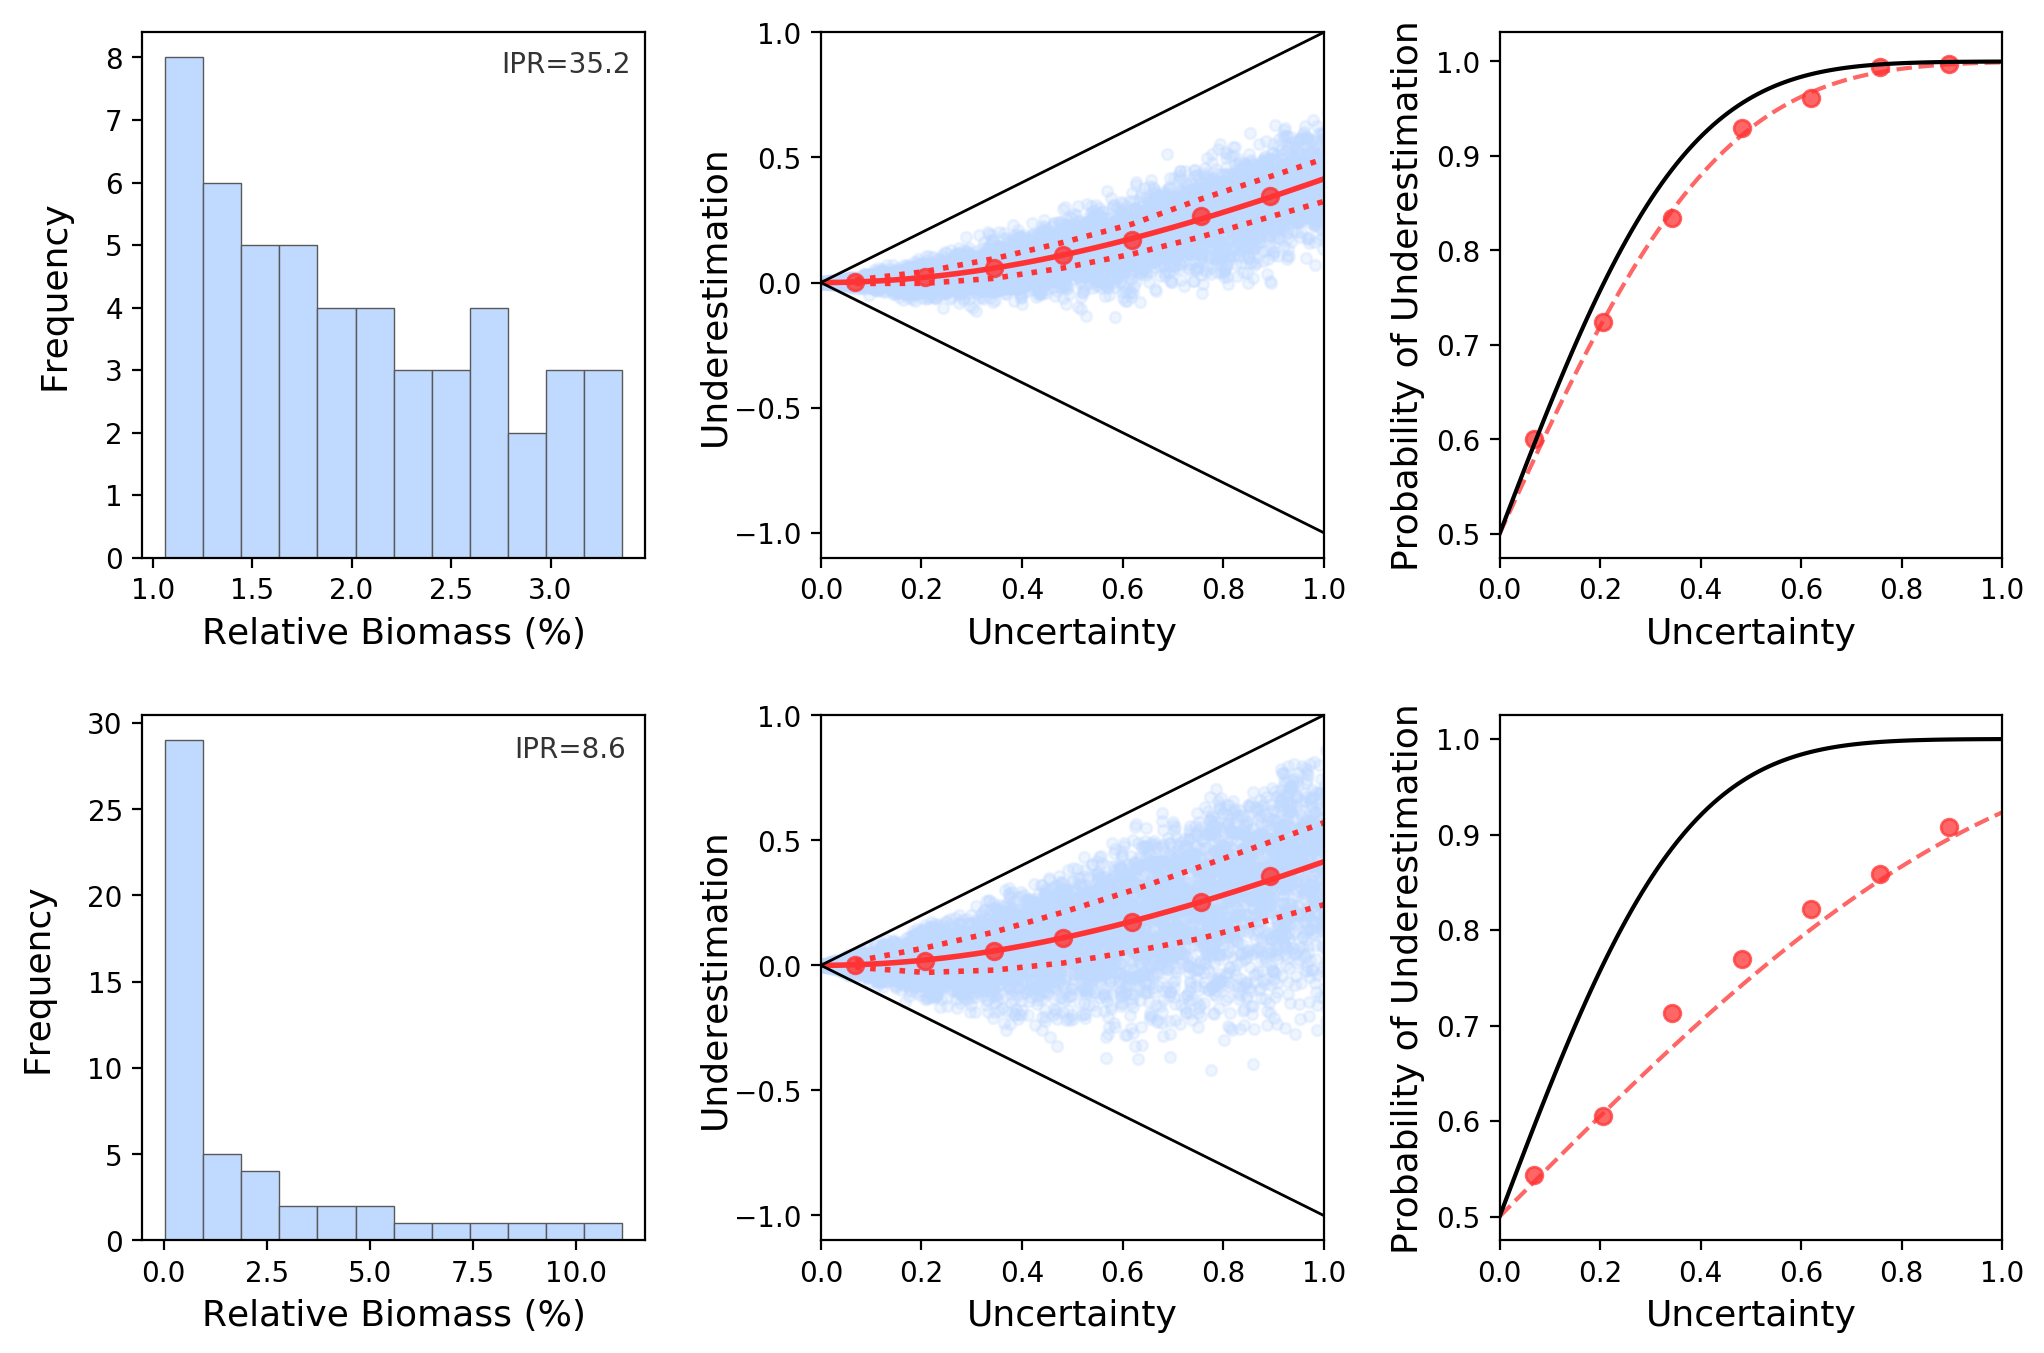

In [25]:
plt.figure(num=None, figsize=(12, 8), dpi=200, facecolor='w', edgecolor='k')


############# Biomass Distributions ###############

plt.subplot(2, 3, 1) 
plt.hist(biomass_1_rel, bins=12, color = (0.75, 0.85, 1), linewidth=0.5, edgecolor=(0.35, 0.35, 0.35))
plt.xlabel("")
plt.text(2.75, 7.75, "IPR="+str(round(ipr_1,1)), fontsize=10, alpha = 0.8)
#plt.xticks([])
#plt.yticks([])
plt.xlabel("Relative Biomass (%)", fontsize=13)
plt.ylabel("Frequency", fontsize=13, labelpad=12)

plt.subplot(2, 3, 4) 
plt.hist(biomass_3_rel, bins=12, color = (0.75, 0.85, 1), linewidth=0.5, edgecolor=(0.35, 0.35, 0.35));
plt.text(8.5, 28, "IPR="+str(round(ipr_3,1)), fontsize=10, alpha = 0.8)
#plt.xticks([])
#plt.yticks([])
plt.xlabel("Relative Biomass (%)", fontsize=13)
plt.ylabel("Frequency", fontsize=13, labelpad=12)


############# Uncertainty vs Underestimation ###############

plt.subplot(2, 3, 2) 
plt.scatter(Non_add_1, Effect_1, alpha = 0.25, color = (0.75, 0.85, 1), s=15)
X = np.sort(Non_add_1)
plt.scatter(bin_1_x, bin_1_y, color = (1, 0.2, 0.2), alpha = 0.8)
plt.plot(bin_1_x, bin_1_y_q25, color = (1, 0.2, 0.2), lw=2, linestyle=':')
plt.plot(bin_1_x, bin_1_y_q75, color = (1, 0.2, 0.2), lw=2, linestyle=':')
plt.plot(X, np.sqrt(X**2+1)-1, color = (1, 0.2, 0.2), lw=2) 
#plt.plot(X, np.sqrt(X**2+1+2*X/np.sqrt(ipr_1))-1, color = (1, 0.2, 0.2), lw=2, linestyle=':')  
#plt.plot(X, np.sqrt(X**2+1-2*X/np.sqrt(ipr_1))-1, color = (1, 0.2, 0.2), lw=2, linestyle=':')
plt.plot(X, X, 'black', lw=1)
plt.plot([0,1,2],[0,-1,0], 'black',lw=1)
plt.xlim(0, 1)
plt.ylim(-1.1, 1)
plt.yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
plt.xlabel("Uncertainty", fontsize=13)
plt.ylabel("Underestimation", fontsize=13, labelpad=1)

plt.subplot(2, 3, 5) 
plt.scatter(Non_add_3, Effect_3, alpha = 0.25, color = (0.75, 0.85, 1), s=15)
X = np.sort(Non_add_3)
plt.scatter(bin_3_x, bin_3_y, color = (1, 0.2, 0.2), alpha = 0.8)
plt.plot(bin_3_x, bin_3_y_q25, color = (1, 0.2, 0.2), lw=2, linestyle=':')
plt.plot(bin_3_x, bin_3_y_q75, color = (1, 0.2, 0.2), lw=2, linestyle=':')
plt.plot(X, np.sqrt(X**2+1)-1, color = (1, 0.2, 0.2), lw=2) 
#plt.plot(X, np.sqrt(X**2+1+2*X/np.sqrt(ipr_3))-1, color = (1, 0.2, 0.2), lw=2, linestyle=':')  
#plt.plot(X, np.sqrt(X**2+1-2*X/np.sqrt(ipr_3))-1, color = (1, 0.2, 0.2), lw=2, linestyle=':')
plt.plot(X, X, 'black', lw=1)
plt.plot([0,1,2],[0,-1,0], 'black',lw=1)
plt.xlim(0, 1)
plt.ylim(-1.1, 1)
plt.yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
plt.xlabel("Uncertainty", fontsize=13)
plt.ylabel("Underestimation", fontsize=13, labelpad=1)


############# Probability of Underestimation ###############

plt.subplot(2, 3, 3) 
plt.scatter(bin_1_x, bin_1_py, color = (1, 0.2, 0.2), alpha=0.75)
plt.xlim(0, 1)
plt.xlabel("Uncertainty", fontsize=13)
plt.ylabel("Probability of Underestimation", fontsize=13)
X2 = np.linspace(0,1,100)
plt.plot(X2, 1.-0.5*betainc((ipr_1-1.)/2., 0.5, 1.-(X2**2)/4), linestyle = "--", alpha=0.75, color = (1, 0.2, 0.2))
plt.plot(X2, 1.-0.5*betainc((50-1.)/2., 0.5, 1.-(X2**2)/4), color=(0, 0, 0))

plt.subplot(2, 3, 6) 
plt.scatter(bin_3_x, bin_3_py, color = (1, 0.2, 0.2), alpha=0.75)
plt.xlim(0, 1);
plt.xlabel("Uncertainty", fontsize=13)
plt.ylabel("Probability of Underestimation", fontsize=13)
X2 = np.linspace(0,1,100)
plt.plot(X2, 1.-0.5*betainc((ipr_3-1.)/2., 0.5, 1.-(X2**2)/4), linestyle = "--", alpha=0.75, color = (1, 0.2, 0.2))
plt.plot(X2, 1.-0.5*betainc((50-1.)/2., 0.5, 1.-(X2**2)/4), color=(0, 0, 0))


plt.subplots_adjust(wspace=0.35, hspace=0.3)



<br>
<br>
<br>

## Figure 5 <a class="anchor" id="5"></a>
[Top](#8)

### Insets

In [14]:
nb = 200

S = 5
sigma = np.ones(S)
x = 1+np.random.uniform(0, 0, size=S)  
Dx_1 = []
Entropy_1 = []
Tot_Bio_1 = []
Stability_1 = []
for i in range(nb):
    y = 0.5*np.random.uniform(-1, 1, size=S)
    Dx_1 = np.concatenate([Dx_1, [norm(y, 2)]])     
    Entropy_1 = np.concatenate([Entropy_1, [abs(entropy(x+y)-entropy(x))]])
    Tot_Bio_1 = np.concatenate([Tot_Bio_1, [abs(sum(y))]])
    Stability_1 =np.concatenate([Stability_1, [abs(stability(x+y, sigma)-stability(x, sigma))]])

S = 10
sigma = np.ones(S)
x = 1+np.random.uniform(0, 0, size=S)
Dx_2 = []
Entropy_2 = []
Tot_Bio_2 = []
Stability_2 = []
for i in range(nb):
    y = 0.5*np.random.uniform(-1, 1, size=S)
    Dx_2 = np.concatenate([Dx_2, [norm(y, 2)]])     
    Entropy_2 = np.concatenate([Entropy_2, [abs(entropy(x+y)-entropy(x))]])
    Tot_Bio_2 = np.concatenate([Tot_Bio_2, [abs(sum(y))]])
    Stability_2 =np.concatenate([Stability_2, [abs(stability(x+y, sigma)-stability(x, sigma))]])


S = 50
sigma = np.ones(S)
x = 1+np.random.uniform(0, 0, size=S)
Dx_3 = []
Entropy_3 = []
Tot_Bio_3 = []
Stability_3 = []
for i in range(nb):
    y = 0.5*np.random.uniform(-1, 1, size=S)
    Dx_3 = np.concatenate([Dx_3, [norm(y, 2)]])     
    Entropy_3 = np.concatenate([Entropy_3, [abs(entropy(x+y)-entropy(x))]])
    Tot_Bio_3 = np.concatenate([Tot_Bio_3, [abs(sum(y))]])
    Stability_3 =np.concatenate([Stability_3, [abs(stability(x+y, sigma)-stability(x, sigma))]])



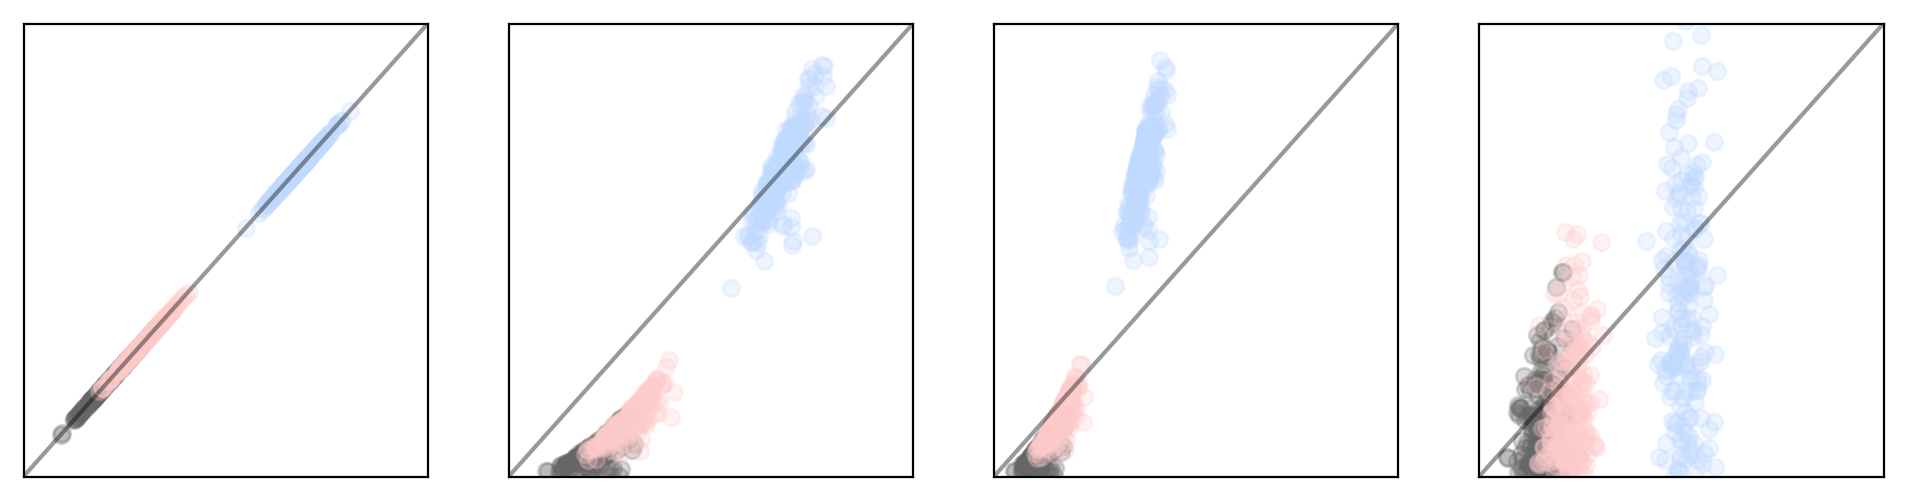

In [15]:
plt.figure(num=None, figsize=(12, 3), dpi=200, facecolor='w', edgecolor='k')

X=np.linspace(0,10,100)

plt.subplot(1, 4, 1) 
plt.scatter(Dx_1, Dx_1, alpha=0.25, color = (0.4, 0.4, 0.4), label="S=5")
plt.scatter(Dx_2, Dx_2, alpha=0.25, color = (1, 0.8, 0.8), label="S=10")
plt.scatter(Dx_3, Dx_3, alpha=0.25, color = (0.75, 0.85, 1), label="S=50")
#plt.legend(fontsize=8)
plt.yticks([])
plt.xticks([])
#plt.xlabel("Distance")
#plt.ylabel("Distance")
plt.plot(X, X, color = (0, 0, 0), alpha=0.4)
plt.xlim(0,3)
plt.ylim(0,3)


plt.subplot(1, 4, 2) 
plt.scatter(Dx_1, Entropy_1, alpha=0.25, color = (0.4, 0.4, 0.4), label="S=5")
plt.scatter(Dx_2, Entropy_2, alpha=0.25, color = (1, 0.8, 0.8), label="S=10")
plt.scatter(Dx_3, Entropy_3, alpha=0.25, color = (0.75, 0.85, 1), label="S=50")
#plt.legend(fontsize=8)
plt.yticks([])
plt.xticks([])
#plt.xlabel("Distance")
#plt.ylabel("Diversity")
plt.plot(X, X, color = (0, 0, 0), alpha=0.4)
plt.xlim(0,3)
plt.ylim(0,3)


plt.subplot(1, 4, 3) 
plt.scatter(Dx_1, Stability_1, alpha=0.25, color = (0.4, 0.4, 0.4), label="S=5")
plt.scatter(Dx_2, Stability_2, alpha=0.25, color = (1, 0.8, 0.8), label="S=10")
plt.scatter(Dx_3, Stability_3, alpha=0.25, color = (0.75, 0.85, 1), label="S=50")
#plt.legend(fontsize=8)
plt.yticks([])
plt.xticks([])
#plt.xlabel("Distance")
#plt.ylabel("Stability")
plt.plot(X, X, color = (0, 0, 0), alpha=0.4)
plt.xlim(0,5.5)
plt.ylim(0,5.5)

plt.subplot(1, 4, 4) 
plt.scatter(Dx_1, Tot_Bio_1, alpha=0.25, color = (0.4, 0.4, 0.4), label="S=5")
plt.scatter(Dx_2, Tot_Bio_2, alpha=0.25, color = (1, 0.8, 0.8), label="S=10")
plt.scatter(Dx_3, Tot_Bio_3, alpha=0.25, color = (0.75, 0.85, 1), label="S=50")
#plt.legend(fontsize=8)
plt.yticks([])
plt.xticks([])
#plt.xlabel("Distance")
#plt.ylabel("Total Biomass");
plt.plot(X, X, color = (0, 0, 0), alpha=0.4)
plt.xlim(0,4)
plt.ylim(0,4)


plt.subplots_adjust(hspace=0.3)


### Main Figure

In [16]:
nb = 50000     # Number of Experiments

###############################################################################################
############################# Communitiy of 5 Species #########################################
###############################################################################################

S = 5

N0 = np.logspace(0, 0.05, S)                        # Initial Biomass Distribution
ent0 = entropy(N0)                                  # Initial Entropy 
tot0 = sum(N0)                                      # Initial Total Biomass
sigma = np.random.uniform(1, 1, size=S)             # Species level CV 
stab0 = stability(N0, sigma)                        # Initial Stability 

grad_ent0 = gradient(entropy, N0)                   # Gradient of Entropy
def stability1(N0):                                 # Defining the function....
    return stability(N0, sigma)                     # .... Stability (Invariability)
grad_stab0 = gradient(stability1, N0)               # Gradient of Stability

r=np.random.uniform(0, 1, size = nb)                # Uncertainty
eps=np.random.uniform(0, 0.1, size = nb)            # Ensuring no extinctions

#### Defining Relevant Vectors ######
under_res1=np.zeros(nb)
uncert_res1=np.zeros(nb)
uncert_ent1=np.zeros(nb)                       
under_ent1=np.zeros(nb)                       
uncert_tot1=np.zeros(nb)                       
under_tot1=np.zeros(nb)   
uncert_stab1=np.zeros(nb)                       
under_stab1=np.zeros(nb)
NL_uncert_ent1=np.zeros(nb)                       
NL_under_ent1=np.zeros(nb)  
NL_uncert_stab1=np.zeros(nb)                       
NL_under_stab1=np.zeros(nb)

pred=N0*np.random.normal(0,1,size=S)                # Prediction
v=0.1*pred/norm(pred)                               # Normalized Prediction


for n in range(nb):                           # Looping over all 'experiments' ...
    
    u = N0*np.random.normal(0, 1, size=S)             
    u = u/norm(u)                                     
    u = r[n]*u                                        # Uncertainty
    w = u+v                                           # True Change = Uncertainty + Prediction
    
    N_exp = N0  + v                                   # Predicted biomass distribution
    N_true = N0 + w                                   # True biomass distribution
        
    predict_ent = entropy(N_exp)                      # expected entropy 
    predict_tot = sum(N_exp)                          # expected total biomass
    predict_stab = stability(N_exp, sigma)            # expected stability
    
    tot_true = sum(N_true)                            # true total biomass
    ent_true = entropy(N_true)                        # true entropy 
    stab_true = stability(N_true, sigma)              # true stability
 

    under_res1[n] = norm(N_true-N0)**2/norm(N_exp-N0)**2-1                  # underestimation at resolved
    uncert_res1[n] = abs(norm(N_true-N0)**2/norm(N_exp-N0)**2-1)            # x1 - uncertainty for the 1D case

    under_ent1[n] = abs(ent_true-ent0)/(abs(predict_ent-ent0)) - 1          # underestimation (projection of entropy)
    uncert_ent1[n] = abs(predict_ent-ent_true)/(abs(predict_ent-ent0))      # uncertainty (projection of entropy)

    under_tot1[n] = abs(tot_true-tot0)/abs(predict_tot-tot0) - 1            # underestimation (projection of total biomass)
    uncert_tot1[n] = abs(predict_tot-tot_true)/abs(predict_tot-tot0)        # uncertainty (projection of total biomass)

    under_stab1[n] = abs(stab_true-stab0)/abs(predict_stab-stab0) - 1       # underestimation (projection of stability)
    uncert_stab1[n] = abs(predict_stab-stab_true)/abs(predict_stab-stab0)   # uncertainty (projection of stability)

    ######### Non-Linear Contribution ############
    
    NL_predict_ent = entropy(N_exp)-np.dot(grad_ent0, v)        
    NL_ent_true = entropy(N_true)-np.dot(grad_ent0, w)    
    
    NL_under_ent1[n] = abs(NL_ent_true-ent0)/(abs(NL_predict_ent-ent0)) - 1             
    NL_uncert_ent1[n] = abs(NL_predict_ent-NL_ent_true)/(abs(predict_ent-ent0))        

    NL_predict_stab = stability1(N_exp)-np.dot(grad_stab0, v)   
    NL_stab_true = stability1(N_true)-np.dot(grad_stab0, w)    
    
    NL_under_stab1[n] = abs(NL_stab_true-stab0)/(abs(NL_predict_stab-stab0)) - 1             
    NL_uncert_stab1[n] = abs(NL_predict_stab-NL_stab_true)/(abs(predict_stab-stab0))        
    
    
############# Binning the Data Using binned_statistic #################    
    
def underestimation(values):
    return len(np.where(values>0.)[0])/(len(values)*1.)
underestimation_res1, bin_edges, binnumber = binned_statistic(uncert_res1, under_res1, statistic=underestimation, bins=20, range=(0, 1.05)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_res1 = bin_edges[1:] - bin_width/2

underestimation_ent1, bin_edges, binnumber = binned_statistic(uncert_ent1, under_ent1, statistic=underestimation, bins=20, range=(0, 1.05)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_ent1 = bin_edges[1:] - bin_width/2

underestimation_tot1, bin_edges, binnumber = binned_statistic(uncert_tot1, under_tot1, statistic=underestimation, bins=20, range=(0, 1.05)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_tot1 = bin_edges[1:] - bin_width/2

underestimation_stab1, bin_edges, binnumber = binned_statistic(uncert_stab1, under_stab1, statistic=underestimation, bins=20, range=(0, 1.05)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_stab1 = bin_edges[1:] - bin_width/2

underestimation_NL_ent1, bin_edges, binnumber = binned_statistic(NL_uncert_ent1, NL_under_ent1, statistic=underestimation, bins=20, range=(0, 1.05)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_NL_ent1 = bin_edges[1:] - bin_width/2

underestimation_NL_stab1, bin_edges, binnumber = binned_statistic(NL_uncert_stab1, NL_under_stab1, statistic=underestimation, bins=20, range=(0, 1.05)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_NL_stab1 = bin_edges[1:] - bin_width/2






###############################################################################################
############################# Communitiy of 10 Species #########################################
###############################################################################################


S = 10

N0 = np.logspace(0, 0.05, S)       
ent0 = entropy(N0)                             
tot0 = sum(N0)                                  
sigma = np.random.uniform(1, 1, size=S)        
stab0 = stability(N0, sigma)                    

grad_ent0 = gradient(entropy, N0)
def stability1(N0):
    return stability(N0, sigma)
grad_stab0 = gradient(stability1, N0)

r=np.random.uniform(0, 1, size = nb)
eps=np.random.uniform(0, 0.1, size = nb)

under_res2=np.zeros(nb)
uncert_res2=np.zeros(nb)

uncert_ent2=np.zeros(nb)                       
under_ent2=np.zeros(nb)                       

uncert_tot2=np.zeros(nb)                       
under_tot2=np.zeros(nb)   

uncert_stab2=np.zeros(nb)                       
under_stab2=np.zeros(nb)

NL_uncert_ent2=np.zeros(nb)                       
NL_under_ent2=np.zeros(nb)  

NL_uncert_stab2=np.zeros(nb)                       
NL_under_stab2=np.zeros(nb)

pred=N0*np.random.normal(0,1,size=S)
v=0.1*pred/norm(pred)

for n in range(nb):
    
    u = N0*np.random.normal(0, 1, size=S)
    u = u/norm(u)
    u = r[n]*u
    w = u+v
     
    N_exp = N0 + v       
    N_true = N0 + w     
        
    predict_ent = entropy(N_exp)                           
    predict_tot = sum(N_exp)                             
    predict_stab = stability(N_exp, sigma)                    

    tot_true = sum(N_true)                               
    ent_true = entropy(N_true)                               
    stab_true = stability(N_true, sigma)                 
 

    under_res2[n] = norm(N_true-N0)**2/norm(N_exp-N0)**2-1                    
    uncert_res2[n] = abs(norm(N_true-N0)**2/norm(N_exp-N0)**2-1)           

    under_ent2[n] = abs(ent_true-ent0)/(abs(predict_ent-ent0)) - 1       
    uncert_ent2[n] = abs(predict_ent-ent_true)/(abs(predict_ent-ent0))    

    under_tot2[n] = abs(tot_true-tot0)/abs(predict_tot-tot0) - 1           
    uncert_tot2[n] = abs(predict_tot-tot_true)/abs(predict_tot-tot0)       

    under_stab2[n] = abs(stab_true-stab0)/abs(predict_stab-stab0) - 1   
    uncert_stab2[n] = abs(predict_stab-stab_true)/abs(predict_stab-stab0)  

    
    NL_predict_ent = entropy(N_exp)-np.dot(grad_ent0, v)        
    NL_ent_true = entropy(N_true)-np.dot(grad_ent0, w)         
    NL_under_ent2[n] = abs(NL_ent_true-ent0)/(abs(NL_predict_ent-ent0)) - 1             
    NL_uncert_ent2[n] = abs(NL_predict_ent-NL_ent_true)/(abs(predict_ent-ent0))        

    NL_predict_stab = stability1(N_exp)-np.dot(grad_stab0, v)    
    NL_stab_true = stability1(N_true)-np.dot(grad_stab0, w)     
    NL_under_stab2[n] = abs(NL_stab_true-stab0)/(abs(NL_predict_stab-stab0)) - 1             
    NL_uncert_stab2[n] = abs(NL_predict_stab-NL_stab_true)/(abs(predict_stab-stab0))        

    
def underestimation(values):
    return len(np.where(values>0.)[0])/(len(values)*1.)
underestimation_res2, bin_edges, binnumber = binned_statistic(uncert_res2, under_res2, statistic=underestimation, bins=20, range=(0, 1.05)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_res2 = bin_edges[1:] - bin_width/2

underestimation_ent2, bin_edges, binnumber = binned_statistic(uncert_ent2, under_ent2, statistic=underestimation, bins=20, range=(0, 1.05)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_ent2 = bin_edges[1:] - bin_width/2

underestimation_tot2, bin_edges, binnumber = binned_statistic(uncert_tot2, under_tot2, statistic=underestimation, bins=20, range=(0, 1.05)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_tot2 = bin_edges[1:] - bin_width/2

underestimation_stab2, bin_edges, binnumber = binned_statistic(uncert_stab2, under_stab2, statistic=underestimation, bins=20, range=(0, 1.05)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_stab2 = bin_edges[1:] - bin_width/2

underestimation_NL_ent2, bin_edges, binnumber = binned_statistic(NL_uncert_ent2, NL_under_ent2, statistic=underestimation, bins=20, range=(0, 1.05)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_NL_ent2 = bin_edges[1:] - bin_width/2

underestimation_NL_stab2, bin_edges, binnumber = binned_statistic(NL_uncert_stab2, NL_under_stab2, statistic=underestimation, bins=20, range=(0, 1.05)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_NL_stab2 = bin_edges[1:] - bin_width/2





###############################################################################################
############################# Communitiy of 50 Species #########################################
###############################################################################################


S = 50

N0 = np.logspace(0, 0.05, S)                   
ent0 = entropy(N0)                              
tot0 = sum(N0)                                   
sigma = np.random.uniform(1, 1, size=S)        
stab0 = stability(N0, sigma)                   


grad_ent0 = gradient(entropy, N0)
def stability1(N0):
    return stability(N0, sigma)
grad_stab0 = gradient(stability1, N0)


r=np.random.uniform(0, 1, size = nb)
eps=np.random.uniform(0, 0.1, size = nb)

under_res3=np.zeros(nb)
uncert_res3=np.zeros(nb)

uncert_ent3=np.zeros(nb)                       
under_ent3=np.zeros(nb)                       

uncert_tot3=np.zeros(nb)                       
under_tot3=np.zeros(nb)   

uncert_stab3=np.zeros(nb)                       
under_stab3=np.zeros(nb)

NL_uncert_ent3=np.zeros(nb)                       
NL_under_ent3=np.zeros(nb)  

NL_uncert_stab3=np.zeros(nb)                       
NL_under_stab3=np.zeros(nb)

pred=N0*np.random.normal(0,1,size=S)
v=0.1*pred/norm(pred)

for n in range(nb):
    
    u = N0*np.random.normal(0, 1, size=S)
    u = u/norm(u)
    u = r[n]*u
    w = u+v
    
    N_exp = N0 + v   
    N_true = N0 + w    
        
    predict_ent = entropy(N_exp)                           
    predict_tot = sum(N_exp)                                  
    predict_stab = stability(N_exp, sigma)                    

    tot_true = sum(N_true)                                   
    ent_true = entropy(N_true)                               
    stab_true = stability(N_true, sigma)                   
 

    under_res3[n] = norm(N_true-N0)**2/norm(N_exp-N0)**2-1                     
    uncert_res3[n] = abs(norm(N_true-N0)**2/norm(N_exp-N0)**2-1)            

    under_ent3[n] = abs(ent_true-ent0)/(abs(predict_ent-ent0)) - 1          
    uncert_ent3[n] = abs(predict_ent-ent_true)/(abs(predict_ent-ent0))        

    under_tot3[n] = abs(tot_true-tot0)/abs(predict_tot-tot0) - 1        
    uncert_tot3[n] = abs(predict_tot-tot_true)/abs(predict_tot-tot0)        

    under_stab3[n] = abs(stab_true-stab0)/abs(predict_stab-stab0) - 1       
    uncert_stab3[n] = abs(predict_stab-stab_true)/abs(predict_stab-stab0)   

    
    NL_predict_ent = entropy(N_exp)-np.dot(grad_ent0, v)   
    NL_ent_true = entropy(N_true)-np.dot(grad_ent0, w)      
    
    NL_under_ent3[n] = abs(NL_ent_true-ent0)/(abs(NL_predict_ent-ent0)) - 1             
    NL_uncert_ent3[n] = abs(NL_predict_ent-NL_ent_true)/(abs(predict_ent-ent0))        

    NL_predict_stab = stability1(N_exp)-np.dot(grad_stab0, v)                
    NL_stab_true = stability1(N_true)-np.dot(grad_stab0, w)                
    NL_under_stab3[n] = abs(NL_stab_true-stab0)/(abs(NL_predict_stab-stab0)) - 1             
    NL_uncert_stab3[n] = abs(NL_predict_stab-NL_stab_true)/(abs(predict_stab-stab0))        

    
def underestimation(values):
    return len(np.where(values>0.)[0])/(len(values)*1.)
underestimation_res3, bin_edges, binnumber = binned_statistic(uncert_res3, under_res3, statistic=underestimation, bins=20, range=(0, 1.05)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_res3 = bin_edges[1:] - bin_width/2

underestimation_ent3, bin_edges, binnumber = binned_statistic(uncert_ent3, under_ent3, statistic=underestimation, bins=20, range=(0, 1.05)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_ent3 = bin_edges[1:] - bin_width/2

underestimation_tot3, bin_edges, binnumber = binned_statistic(uncert_tot3, under_tot3, statistic=underestimation, bins=20, range=(0, 1.05)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_tot3 = bin_edges[1:] - bin_width/2

underestimation_stab3, bin_edges, binnumber = binned_statistic(uncert_stab3, under_stab3, statistic=underestimation, bins=20, range=(0, 1.05)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_stab3 = bin_edges[1:] - bin_width/2

underestimation_NL_ent3, bin_edges, binnumber = binned_statistic(NL_uncert_ent3, NL_under_ent3, statistic=underestimation, bins=20, range=(0, 1.05)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_NL_ent3 = bin_edges[1:] - bin_width/2

underestimation_NL_stab3, bin_edges, binnumber = binned_statistic(NL_uncert_stab3, NL_under_stab3, statistic=underestimation, bins=20, range=(0, 1.05)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_NL_stab3 = bin_edges[1:] - bin_width/2

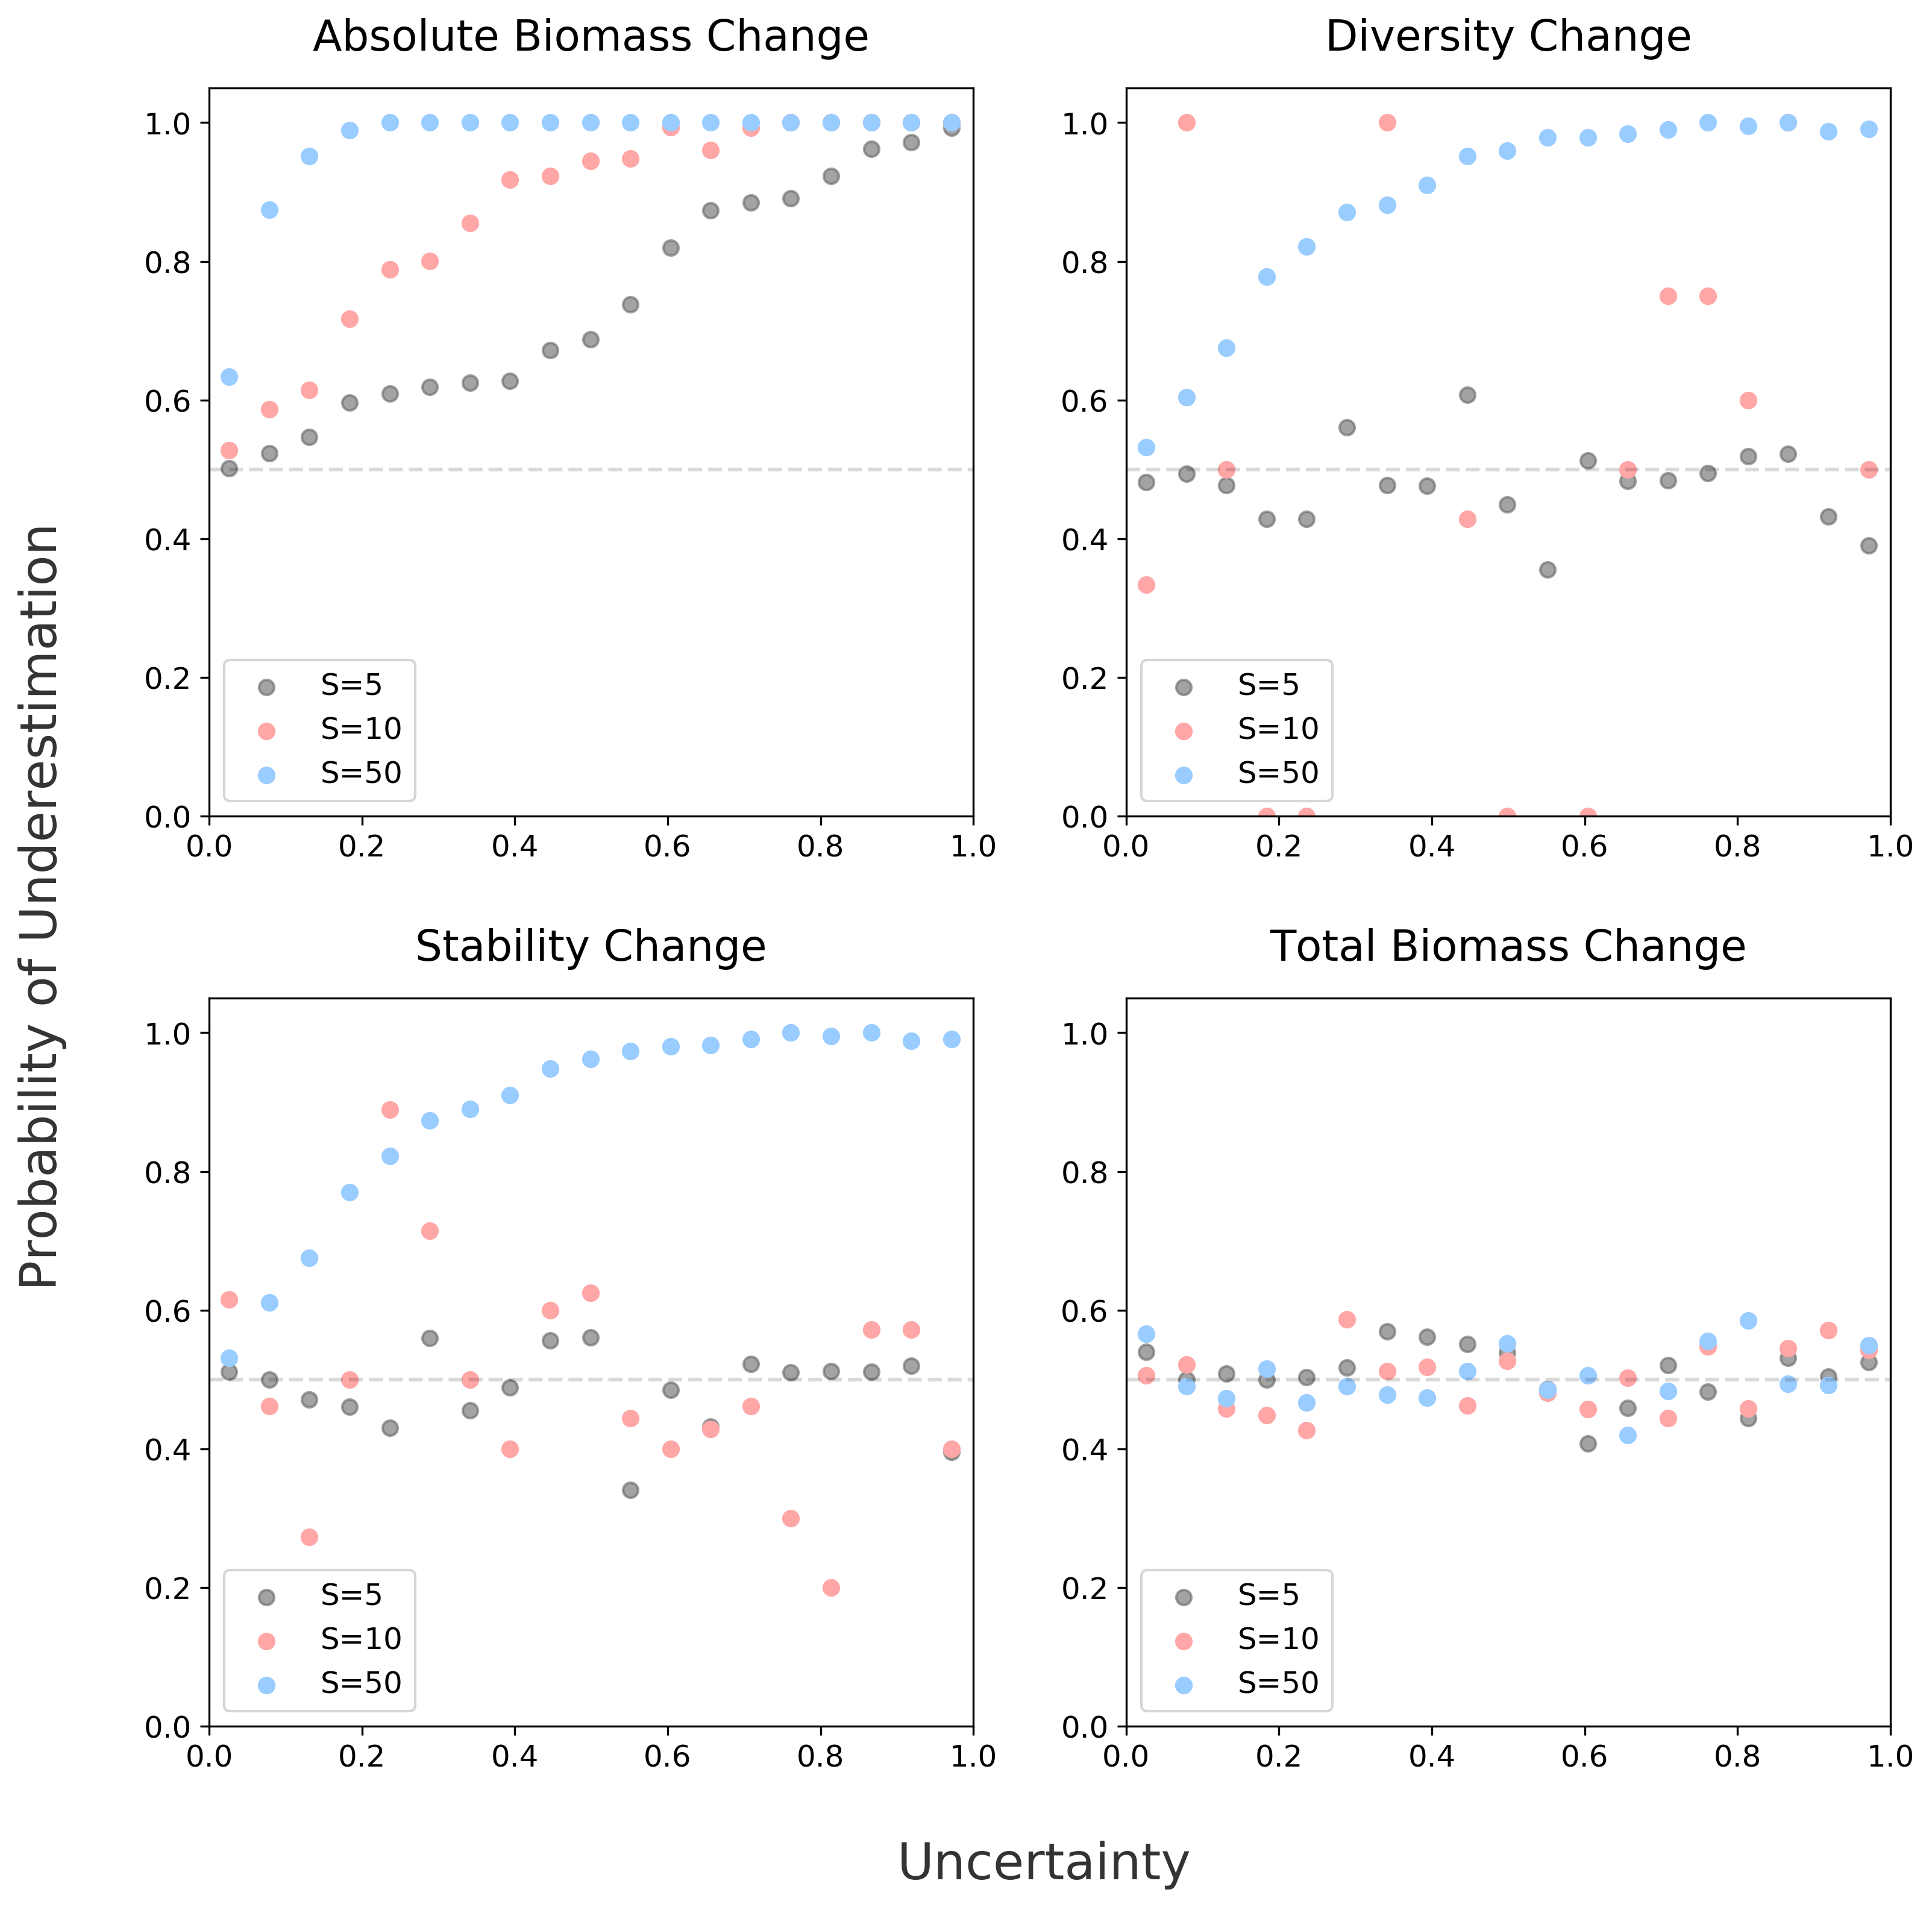

In [17]:
######## Figure 4 ##########

plt.figure(num=None, figsize=(12, 12), dpi=300, facecolor='w', edgecolor='k')


########## Absolute Biomass Change - Euclidean distance ##############
plt.subplot(2, 2, 1) 
plt.scatter(bin_centers_res1, underestimation_res1, alpha=0.6, color = (0.4, 0.4, 0.4), label="S=5")
plt.scatter(bin_centers_res2, underestimation_res2, alpha=1, color = (1, 0.65, 0.65), label="S=10")
plt.scatter(bin_centers_res3, underestimation_res3, alpha=1, color = (0.6, 0.8, 1), label="S=50")
plt.title("Absolute Biomass Change", fontsize = 17, pad=15)
plt.xlim(0, 1.0)
plt.ylim(0., 1.05)
plt.legend(fontsize=12, loc="lower left");
plt.hlines(0.5, 0, 1, color= (0, 0, 0), alpha =0.15, linestyles = "dashed")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


########## Diversity - Entropy ##############
plt.subplot(2, 2, 2) 
plt.scatter(bin_centers_ent1, underestimation_ent1, alpha=0.6, color = (0.4, 0.4, 0.4), label="S=5")
plt.scatter(bin_centers_ent2, underestimation_ent2, alpha=1, color = (1, 0.65, 0.65), label="S=10")
plt.scatter(bin_centers_ent3, underestimation_ent3, alpha=1, color = (0.6, 0.8, 1), label="S=50")
plt.title("Diversity Change", fontsize = 17, pad=15)
plt.xlim(0, 1.0)
plt.ylim(0, 1.05)
plt.legend(fontsize=12, loc="lower left");
plt.hlines(0.5, 0, 1, color= (0, 0, 0), alpha =0.15, linestyles = "dashed")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


########## Stability - Invariability ##############
plt.subplot(2, 2, 3) 
plt.scatter(bin_centers_stab1, underestimation_stab1, alpha=0.6, color = (0.4, 0.4, 0.4), label="S=5")
plt.scatter(bin_centers_stab2, underestimation_stab2, alpha=1, color = (1, 0.65, 0.65), label="S=10")
plt.scatter(bin_centers_stab3, underestimation_stab3, alpha=1, color = (0.6, 0.8, 1), label="S=50")
plt.title("Stability Change", fontsize = 17, pad=15)
plt.xlim(0, 1.0)
plt.ylim(0, 1.05)
plt.legend(fontsize=12, loc="lower left");
plt.hlines(0.5, 0, 1, color= (0, 0, 0), alpha =0.15, linestyles = "dashed")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


########## Functioning - Total Biomass ##############
plt.subplot(2, 2, 4) 
plt.scatter(bin_centers_tot1, underestimation_tot1, alpha=0.6, color = (0.4, 0.4, 0.4), label="S=5")
plt.scatter(bin_centers_tot2, underestimation_tot2, alpha=1, color = (1, 0.65, 0.65), label="S=10")
plt.scatter(bin_centers_tot3, underestimation_tot3, alpha=1, color = (0.6, 0.8, 1), label="S=50")
plt.title("Total Biomass Change", fontsize = 17, pad=15)
plt.xlim(0, 1.0)
plt.ylim(0, 1.05)
plt.legend(fontsize=12, loc="lower left");
plt.hlines(0.5, 0, 1, color= (0, 0, 0), alpha =0.15, linestyles = "dashed")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

########## Annotations ##############
plt.text(-0.3, -.22, "Uncertainty", fontsize=20, alpha = 0.8)
plt.text(-1.45, 1.68, "Probability of Underestimation", fontsize=20, alpha = 0.8, rotation=90);


plt.subplots_adjust(hspace=0.25)

<br>
<br>
<br>

## Figure S1 <a class="anchor" id="6"></a>
[Top](#8)


In [18]:
nb=20000                                       # Number of "experiments"


###############################################################################################
####################### Communitiy of 50 Species, IPR High ####################################
###############################################################################################


S=50                                           # Number of species
Bio= np.logspace(0, 0.2, S)                    # Biomass Distribution
ipr1= norm(Bio,2)**4/norm(Bio,4)**4            # IPR
Grad_Ent=gradient(entropy,Bio)                 # Gradient of Entropy
sigma = np.random.uniform(0.5, 1.5, size=S)    # Species level CV 
def stability1(N0):                            # Stability...
    return stability(N0, sigma)                # ... function
Grad_Stab=gradient(stability1,Bio)             # Gradient of Stability
Non_add=np.linspace(0.001, 1.0,nb)             # Uncertainty Magnitude

##### Defining Relevant Vectors #####
Non_add_F=np.zeros(nb)
Effect_F=np.zeros(nb)
Non_add_F2=np.zeros(nb)
Effect_F2=np.zeros(nb)
Effect_D=np.zeros(nb)
Non_add_D=np.zeros(nb)

Add=Bio*np.random.normal(0,1,size=S)           # Prediction
v=0.1*Add/norm(Add)                            # Normalized

for i in range(nb):                            # Looping over the experiments.. 

    u=Bio*np.random.normal(0,1,size=S)         # Uniform sampling...
    u=u/norm(u)                                #...of the hypersphere...
    u=0.1*Non_add[i]*u                         #...of length non add
    w=u+v
    p=2
    
    Effect_D[i]=1/2. + np.sign(norm(w,p)**2/norm(v,p)**2-1.)/2.    # Underestimation (Euclidean distance) 
    Non_add_D[i]=abs(norm(w,p)**2/norm(v,p)**2-1.)                 # Uncertainty (Euclidean distance)
    
    F_add=entropy(Bio+v)-entropy(Bio)-np.dot(Grad_Ent,v)           # Entropy prediction
    F_nad=entropy(Bio+w)-entropy(Bio)-np.dot(Grad_Ent,w)           # Entropy uncertainty 
    
    Non_add_F[i]=abs(F_nad-F_add)/abs(F_add)                       # Uncertainty (Entropy)
    Effect_F[i]=1./2 + np.sign(abs(F_nad)/abs(F_add)-1.)/2         # Underestimation (Entropy)

    F_add2=stability1(Bio+v)-stability1(Bio)-np.dot(Grad_Stab,v)   # Stability prediction
    F_nad2=stability1(Bio+w)-stability1(Bio)-np.dot(Grad_Stab,w)   # Stability uncertainty
    
    Non_add_F2[i]=abs(F_nad2-F_add2)/abs(F_add2)                   # Uncertainty (Stability)
    Effect_F2[i]=1./2 + np.sign(abs(F_nad2)/abs(F_add2)-1.)/2      # Underestimation (Stability)

    
######## Binning ######### 

### Euclidean Distance ###
index_D=np.where(Non_add_D<1.0)[0]
bin_Euc1_py, bin_edges, binnumber = binned_statistic(Non_add_D[index_D],Effect_D[index_D], statistic=underestimation, bins=18, range=(0, 1.0)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_Euc1_x = bin_edges[1:] - bin_width/2

### Entropy ###
index_F=np.where(Non_add_F<1.0)[0]
bin_Ent1_py, bin_edges, binnumber = binned_statistic(Non_add_F[index_F],Effect_F[index_F], statistic=underestimation, bins=18, range=(0, 1.0)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_Ent1_x = bin_edges[1:] - bin_width/2

### Stability ###
index_F2=np.where(Non_add_F2<1.0)[0]
bin_Stab1_py, bin_edges, binnumber = binned_statistic(Non_add_F2[index_F2],Effect_F2[index_F2], statistic=underestimation, bins=18, range=(0, 1.0)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_Stab1_x = bin_edges[1:] - bin_width/2



###############################################################################################
###################### Communitiy of 50 Species, IPR Medium ###################################
###############################################################################################


S=50         
Bio= np.logspace(0, 1., S)
ipr2= norm(Bio,2)**4/norm(Bio,4)**4
Grad_Ent=gradient(entropy,Bio)
sigma = np.random.uniform(0.5, 1.5, size=S)      
def stability1(N0):
    return stability(N0, sigma)
Grad_Stab=gradient(stability1,Bio)

Non_add=np.linspace(0.001, 1.0,nb)   
Non_add_F=np.zeros(nb)
Effect_F=np.zeros(nb)
Non_add_F2=np.zeros(nb)
Effect_F2=np.zeros(nb)
Effect_D=np.zeros(nb)
Non_add_D=np.zeros(nb)

Add=Bio*np.random.normal(0,1,size=S)
v=0.1*Add/norm(Add)                      

for i in range(nb):
    u=Bio*np.random.normal(0,1,size=S)       
    u=u/norm(u)                          
    u=0.1*Non_add[i]*u                      
    w=u+v
    p=2
    Effect_D[i]=1/2. + np.sign(norm(w,p)**2/norm(v,p)**2-1.)/2.
    Non_add_D[i]=abs(norm(w,p)**2/norm(v,p)**2-1.)              
    F_add=entropy(Bio+v)-entropy(Bio)-np.dot(Grad_Ent,v)   
    F_nad=entropy(Bio+w)-entropy(Bio)-np.dot(Grad_Ent,w)   
    Non_add_F[i]=abs(F_nad-F_add)/abs(F_add)                
    Effect_F[i]=1./2 + np.sign(abs(F_nad)/abs(F_add)-1.)/2
    F_add2=stability1(Bio+v)-stability1(Bio)-np.dot(Grad_Stab,v)  
    F_nad2=stability1(Bio+w)-stability1(Bio)-np.dot(Grad_Stab,w)   
    Non_add_F2[i]=abs(F_nad2-F_add2)/abs(F_add2)                  
    Effect_F2[i]=1./2 + np.sign(abs(F_nad2)/abs(F_add2)-1.)/2

    
######## Binning ######### 

### Euclidean Distance ###
index_D=np.where(Non_add_D<1.0)[0]
bin_Euc2_py, bin_edges, binnumber = binned_statistic(Non_add_D[index_D],Effect_D[index_D], statistic=underestimation, bins=18, range=(0, 1.0)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_Euc2_x = bin_edges[1:] - bin_width/2

### Entropy ###
index_F=np.where(Non_add_F<1.0)[0]
bin_Ent2_py, bin_edges, binnumber = binned_statistic(Non_add_F[index_F],Effect_F[index_F], statistic=underestimation, bins=18, range=(0, 1.0)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_Ent2_x = bin_edges[1:] - bin_width/2

### Stability ###
index_F2=np.where(Non_add_F2<1.0)[0]
bin_Stab2_py, bin_edges, binnumber = binned_statistic(Non_add_F2[index_F2],Effect_F2[index_F2], statistic=underestimation, bins=18, range=(0, 1.0)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_Stab2_x = bin_edges[1:] - bin_width/2


###############################################################################################
####################### Communitiy of 50 Species, IPR Low #####################################
###############################################################################################

S=50         
Bio= np.logspace(0, 3., S)
ipr3= norm(Bio,2)**4/norm(Bio,4)**4
Grad_Ent=gradient(entropy,Bio)
sigma = np.random.uniform(0.5, 1.5, size=S)      
def stability1(N0):
    return stability(N0, sigma)
Grad_Stab=gradient(stability1,Bio)

Non_add=np.linspace(0.001, 1.0, nb)  
Non_add_F=np.zeros(nb)
Effect_F=np.zeros(nb)
Non_add_F2=np.zeros(nb)
Effect_F2=np.zeros(nb)
Effect_D=np.zeros(nb)
Non_add_D=np.zeros(nb)
Add=Bio*np.random.normal(0,1,size=S)     
v=0.1*Add/norm(Add)                      

for i in range(nb):
    u=Bio*np.random.normal(0,1,size=S)      
    u=u/norm(u)                        
    u=0.1*Non_add[i]*u                  
    w=u+v
    p=2  
    Effect_D[i]=1/2. + np.sign(norm(w,p)**2/norm(v,p)**2-1.)/2.
    Non_add_D[i]=abs(norm(w,p)**2/norm(v,p)**2-1.)             
    F_add=entropy(Bio+v)-entropy(Bio)-np.dot(Grad_Ent,v)  
    F_nad=entropy(Bio+w)-entropy(Bio)-np.dot(Grad_Ent,w)  
    Non_add_F[i]=abs(F_nad-F_add)/abs(F_add)                  
    Effect_F[i]=1./2 + np.sign(abs(F_nad)/abs(F_add)-1.)/2
    F_add2=stability1(Bio+v)-stability1(Bio)-np.dot(Grad_Stab,v)  
    F_nad2=stability1(Bio+w)-stability1(Bio)-np.dot(Grad_Stab,w)  
    Non_add_F2[i]=abs(F_nad2-F_add2)/abs(F_add2)                 
    Effect_F2[i]=1./2 + np.sign(abs(F_nad2)/abs(F_add2)-1.)/2

    
######## Binning ######### 

### Euclidean Distance ###
index_D=np.where(Non_add_D<1.0)[0]
bin_Euc3_py, bin_edges, binnumber = binned_statistic(Non_add_D[index_D],Effect_D[index_D], statistic=underestimation, bins=18, range=(0, 1.0)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_Euc3_x = bin_edges[1:] - bin_width/2

### Entropy ###
index_F=np.where(Non_add_F<1.0)[0]
bin_Ent3_py, bin_edges, binnumber = binned_statistic(Non_add_F[index_F],Effect_F[index_F], statistic=underestimation, bins=18, range=(0, 1.0)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_Ent3_x = bin_edges[1:] - bin_width/2

### Stability ###
index_F2=np.where(Non_add_F2<1.0)[0]
bin_Stab3_py, bin_edges, binnumber = binned_statistic(Non_add_F2[index_F2],Effect_F2[index_F2], statistic=underestimation, bins=18, range=(0, 1.0)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_Stab3_x = bin_edges[1:] - bin_width/2

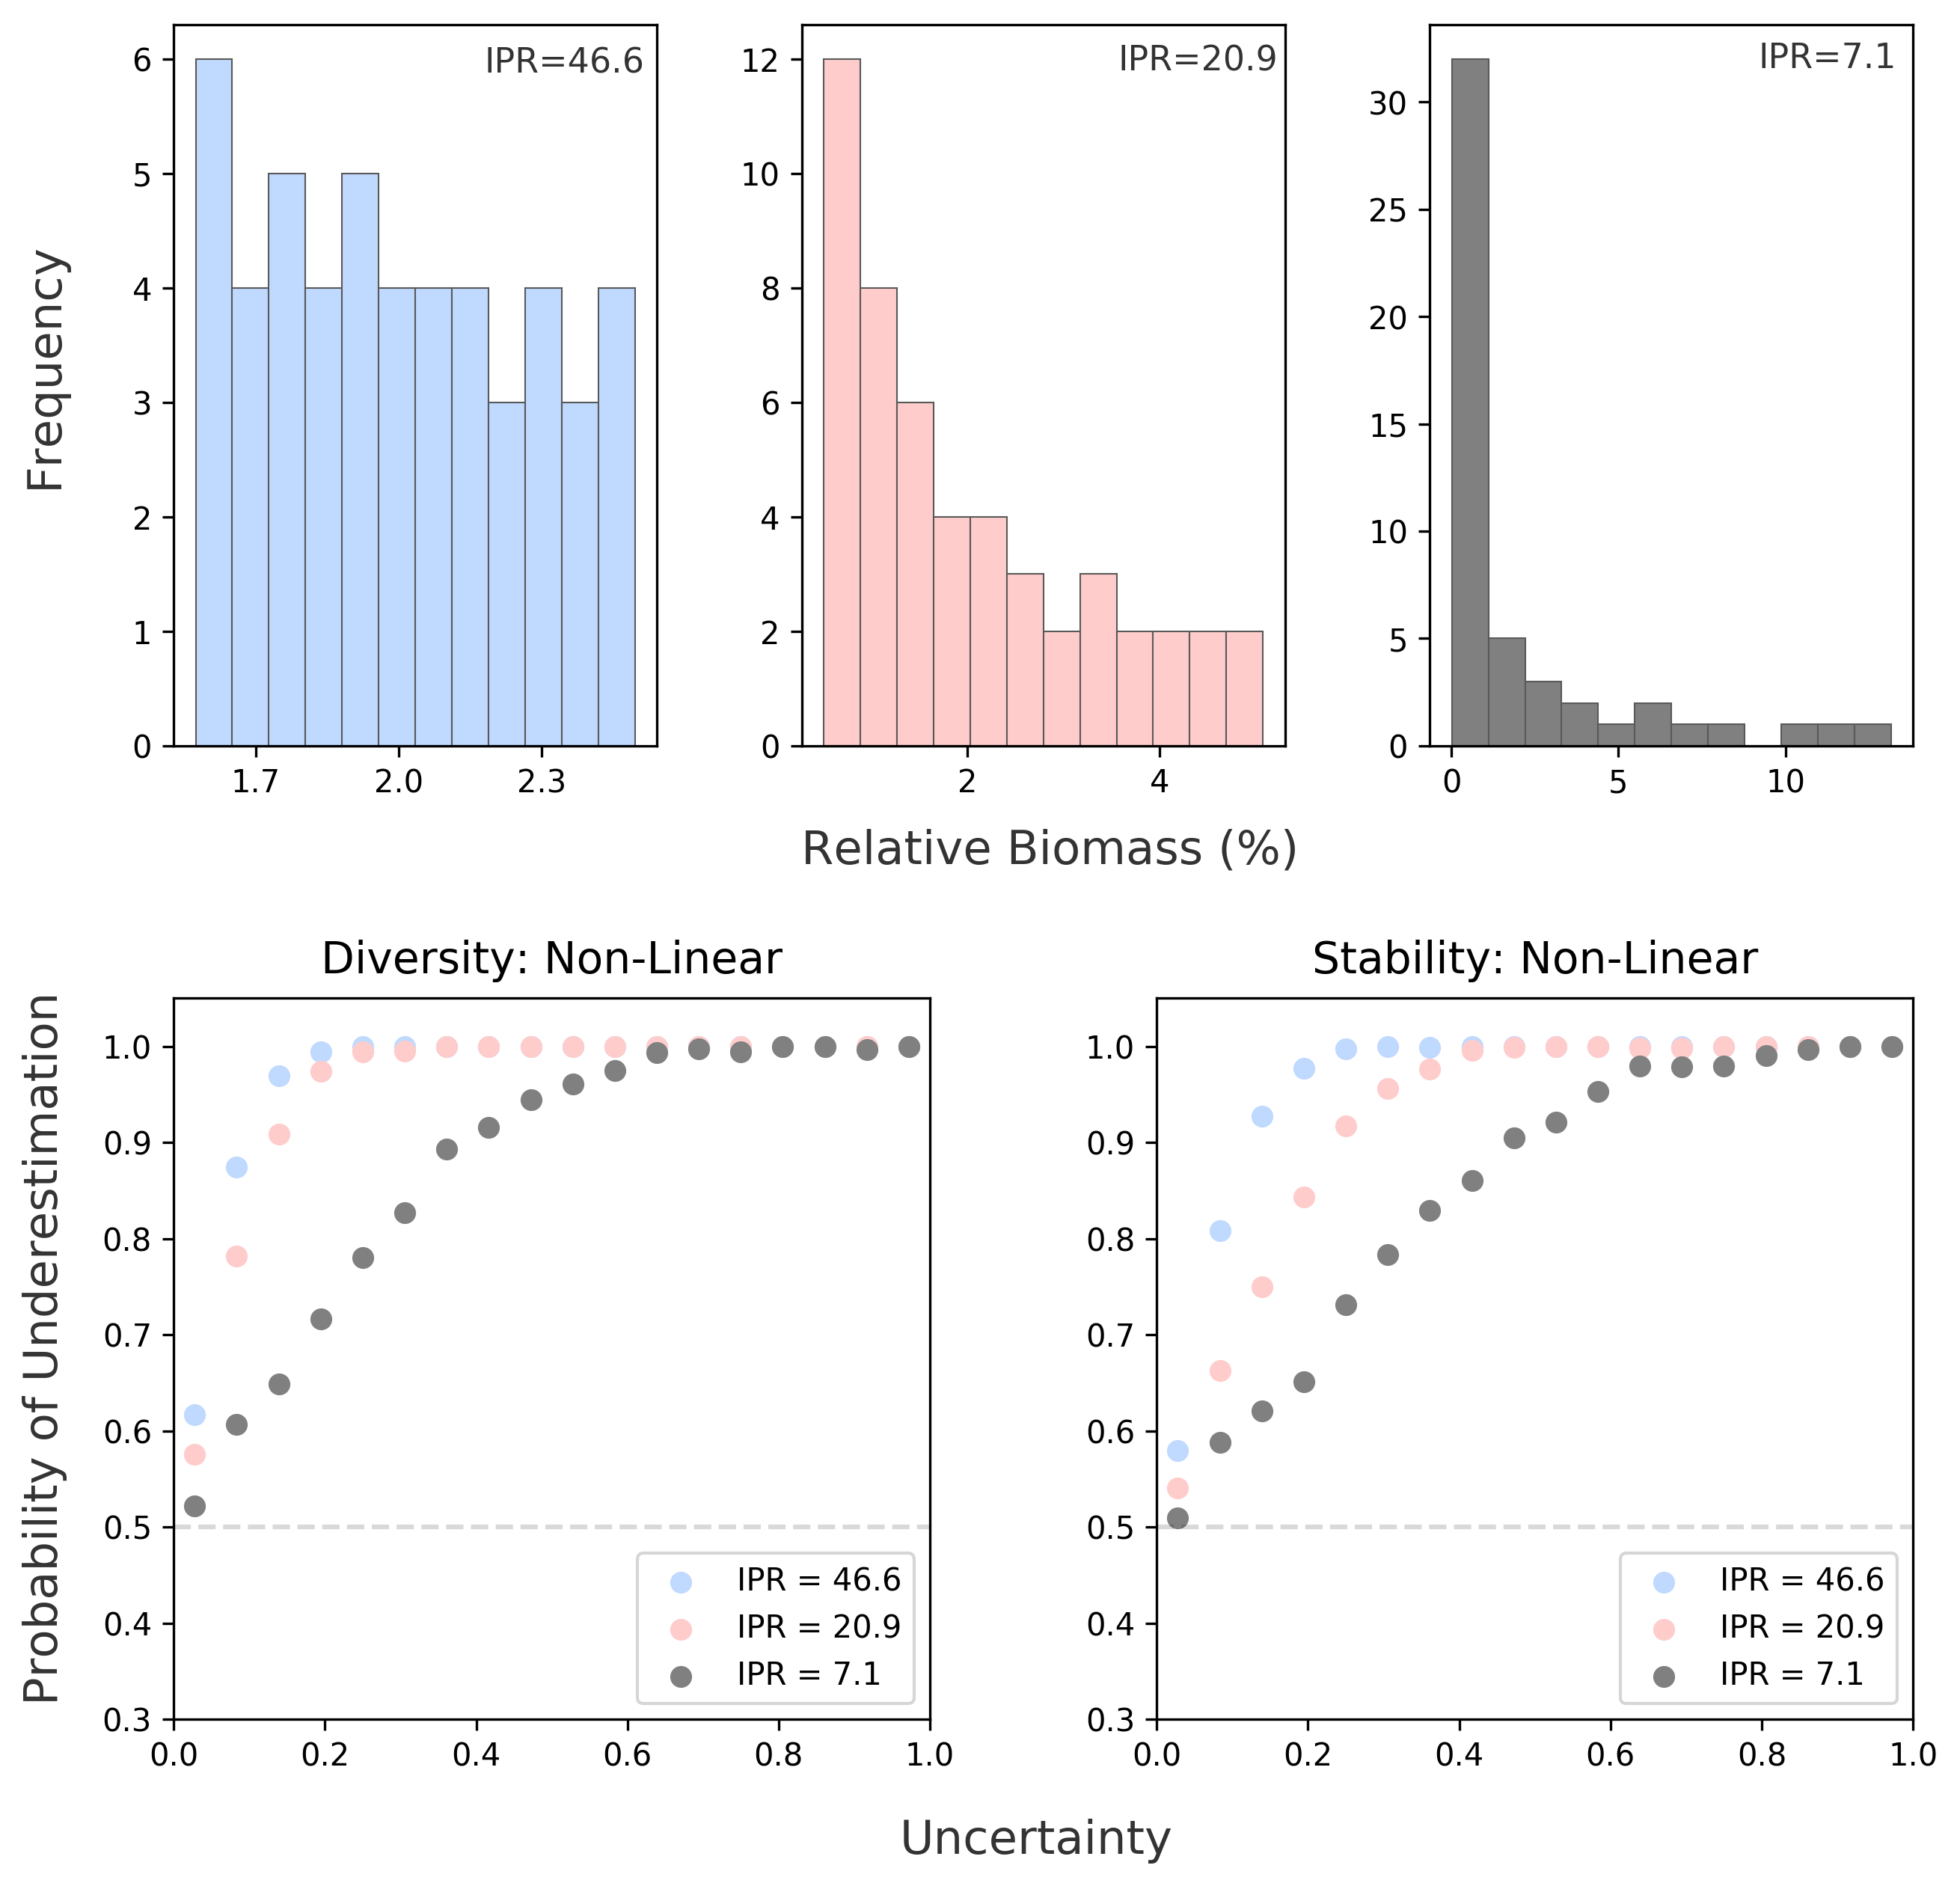

In [19]:
########### Prep ############
S=50
biomass_1 = np.logspace(0, .2, S)         
biomass_2 = np.logspace(0, 1., S)         
biomass_3 = np.logspace(0, 3., S)         
biomass_1_rel = 100*biomass_1/sum(biomass_1)
biomass_2_rel = 100*biomass_2/sum(biomass_2)
biomass_3_rel = 100*biomass_3/sum(biomass_3)
norm_Bio_1 = biomass_1/norm(biomass_1)
norm_Bio_2 = biomass_2/norm(biomass_2)
norm_Bio_3 = biomass_3/norm(biomass_3)
ipr1 = 1/sum(norm_Bio_1**4)
ipr2 = 1/sum(norm_Bio_2**4)
ipr3 =  1/sum(norm_Bio_3**4)


####### Figure 5 #########
plt.figure(num=None, figsize=(10, 10), dpi=300, facecolor='w', edgecolor='k')


###################### Biomass Distributions ##############################
plt.subplot(2, 3, 1) 
plt.hist(biomass_1_rel, bins=12, color = (0.75, 0.85, 1), linewidth=0.5, edgecolor=(0.35, 0.35, 0.35))
plt.text(2.18, 5.88, "IPR="+str(round(ipr1,1)), fontsize=11, alpha = 0.8)
plt.xticks([1.7, 2.0, 2.3])

plt.subplot(2, 3, 2) 
plt.hist(biomass_2_rel, bins=12, color = (1, 0.8, 0.8), linewidth=0.5, edgecolor=(0.35, 0.35, 0.35))
plt.text(3.57, 11.8, "IPR="+str(round(ipr2,1)), fontsize=11, alpha = 0.8)

plt.subplot(2, 3, 3) 
plt.hist(biomass_3_rel, bins=12, color = (0.5, 0.5, 0.5), linewidth=0.5, edgecolor=(0.35, 0.35, 0.35))
plt.text(9.19, 31.6, "IPR="+str(round(ipr3,1)), fontsize=11, alpha = 0.8)


###################### Diversity ##############################
plt.subplot(2, 2, 3) 
plt.scatter(bin_Ent1_x, bin_Ent1_py, label="IPR = "+str(round(ipr1, 1)), color = (0.75, 0.85, 1))
plt.scatter(bin_Ent2_x, bin_Ent2_py, label="IPR = "+str(round(ipr2, 1)), color = (1, 0.8, 0.8))
plt.scatter(bin_Ent3_x, bin_Ent3_py, label="IPR = "+str(round(ipr3, 1)), color = (0.5, 0.5, 0.5))
plt.legend(fontsize=10, loc="lower right")
plt.title("Diversity: Non-Linear", fontsize=14, pad=8)
plt.xlim(0, 1.0)
plt.ylim(0.3, 1.05)
plt.hlines(0.5, 0, 1, color= (0, 0, 0), alpha =0.15, linestyles = "dashed")


###################### Stability ##############################
plt.subplot(2, 2, 4) 
plt.scatter(bin_Stab1_x, bin_Stab1_py, label="IPR = "+str(round(ipr1, 1)), color = (0.75, 0.85, 1))
plt.scatter(bin_Stab2_x, bin_Stab2_py, label="IPR = "+str(round(ipr2, 1)), color = (1, 0.8, 0.8))
plt.scatter(bin_Stab3_x, bin_Stab3_py, label="IPR = "+str(round(ipr3, 1)), color = (0.5, 0.5, 0.5))
plt.legend(fontsize=10, loc="lower right")
plt.title("Stability: Non-Linear", fontsize=14, pad=8)
plt.xlim(0, 1.0)
plt.ylim(0.3, 1.05);
plt.hlines(0.5, 0, 1, color= (0, 0, 0), alpha =0.15, linestyles = "dashed")


###################### Annotations ##############################
plt.text(-1.5, 1.8, "Frequency", fontsize=15, alpha = 0.8, rotation=90);
plt.text(-0.47, 1.19, "Relative Biomass (%)", fontsize=15, alpha = 0.8)
plt.text(-0.34, 0.16, "Uncertainty", fontsize=15, alpha = 0.8)
plt.text(-1.5, 1.02, "Probability of Underestimation", fontsize=15, alpha = 0.8, rotation=90);
plt.subplots_adjust(hspace=0.35, wspace=0.3)

<br>
<br>
<br>

## Figure 6 <a class="anchor" id="7"></a>
[Top](#8)

In [20]:
#################################################################
###################### 1 Function ###############################
#################################################################


S=20                           # Number of Species
Sf=1                           # Number of Functions
Bio = np.logspace(0, 0.8, S)   # Biomass Distribution (IPR ~ 10)
direction_F = 0.               # direction of the function
direction_P = 0.               # direction of the perturbation 
Functions = direction_F+np.random.normal(0, 1, size=(Sf, S))   # Matrix made up of Sf arrays of S components - gradient of the functions, sensitivity of the function 
nb=50000                                     # Number of 'experiments'
Non_add=np.random.uniform(0, 2, size = nb)   # Magnitude of uncertainty for each 'experiment'

####### Defining relevant vectors ########
Effect=np.zeros(nb)
Effect_F=np.zeros(nb)
Non_add_Fun=np.zeros(nb)
Effect_F_ab=np.zeros(nb)
Non_add_Fun_ab=np.zeros(nb)

for n in range(nb):                            # first loop, over all experiments
    Add = Bio*np.random.normal(0, 1, size=S)   # prediction 
    Add = Add/norm(Add)                        # normalized  
    u=Bio*np.random.normal(0,1,size=S)         # uniform sampling of the ...
    u=u/norm(u)                                # ... hypersphere around ...
    u=Non_add[n]*u                             # ... prediction = uncertainty
    Effect[n]=norm(Add+u)-1.                   # underestimation
    F_add = []
    F_nad = []
    for nf in range(Sf):                       # second loop, over all functions 
        F_add = np.concatenate([F_add, [np.dot(Functions[nf,:], Add)]])
        F_nad = np.concatenate([F_nad, [np.dot(Functions[nf,:], u)]])
        
    Non_add_Fun[n]=norm(F_nad)/norm(F_add)          # length of the vector - amplitude of non-additivity
    Effect_F[n]=norm(F_add+F_nad)/norm(F_add)-1.
    Non_add_Fun_ab[n]=norm(F_nad)                   # absolute, not relative
    Effect_F_ab[n]=norm(F_add+F_nad)-norm(F_add)
    
######## Binning ######### 
Subset = np.where(Non_add_Fun<2)[0]
bin_F1_py, bin_edges, binnumber = binned_statistic(Non_add_Fun[Subset], Effect_F[Subset], statistic=underestimation, bins=12, range=(0, 2.0)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_F1_x = bin_edges[1:] - bin_width/2



#################################################################
###################### 2 Functions ###############################
#################################################################

S=20 
Sf=2    # number of functions
Bio = np.logspace(0, 0.8, S)


direction_F = 0.   # direction of the function
direction_P = 0.   # direction of the perturbation 

Functions = direction_F+np.random.normal(0, 1, size=(Sf, S))   # Matrix made up of Sf arrays of S components - gradient of the functions, sensitivity of the function 

nb=50000                                      # number of 'experiments'
Non_add=np.random.uniform(0, 2, size = nb)   # drawing the non-additivity for each 'experiment'
Effect=np.zeros(nb)
Effect_F=np.zeros(nb)
Non_add_Fun=np.zeros(nb)
Effect_F_ab=np.zeros(nb)
Non_add_Fun_ab=np.zeros(nb)

for n in range(nb):
    Add = Bio*np.random.normal(0, 1, size=S)       # additive expectation 
    Add = Add/norm(Add)                        # normalized  
    u=Bio*np.random.normal(0,1,size=S)             # uniform sampling of the hypersphere around the additive expectation
    u=u/norm(u)
    u=Non_add[n]*u                             # non-additivity 
    Effect[n]=norm(Add+u)-1.
    F_add = []
    F_nad = []
    for nf in range(Sf):
        F_add = np.concatenate([F_add, [np.dot(Functions[nf,:], Add)]])
        F_nad = np.concatenate([F_nad, [np.dot(Functions[nf,:], u)]])
        
    Non_add_Fun[n]=norm(F_nad)/norm(F_add)          # length of the vector - amplitude of non-additivity (not relative - because this sometimes creates really big values)
    Effect_F[n]=norm(F_add+F_nad)/norm(F_add)-1.
    Non_add_Fun_ab[n]=norm(F_nad)                   # absolute, not relative
    Effect_F_ab[n]=norm(F_add+F_nad)-norm(F_add)
    
######## Binning ######### 
Subset = np.where(Non_add_Fun<2)[0]
bin_F2_py, bin_edges, binnumber = binned_statistic(Non_add_Fun[Subset], Effect_F[Subset], statistic=underestimation, bins=12, range=(0, 2.0)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_F2_x = bin_edges[1:] - bin_width/2


#################################################################
###################### 3 Functions ###############################
#################################################################

S=20 
Sf=3    # number of functions
Bio = np.logspace(0, 0.8, S)


direction_F = 0.   # direction of the function
direction_P = 0.   # direction of the perturbation 

Functions = direction_F+np.random.normal(0, 1, size=(Sf, S))   # Matrix made up of Sf arrays of S components - gradient of the functions, sensitivity of the function 

nb=50000                                      # number of 'experiments'
Non_add=np.random.uniform(0, 2, size = nb)   # drawing the non-additivity for each 'experiment'
Effect=np.zeros(nb)
Effect_F=np.zeros(nb)
Non_add_Fun=np.zeros(nb)
Effect_F_ab=np.zeros(nb)
Non_add_Fun_ab=np.zeros(nb)

for n in range(nb):
    Add = Bio*np.random.normal(0, 1, size=S)       # additive expectation 
    Add = Add/norm(Add)                        # normalized  
    u=Bio*np.random.normal(0,1,size=S)             # uniform sampling of the hypersphere around the additive expectation
    u=u/norm(u)
    u=Non_add[n]*u                             # non-additivity 
    Effect[n]=norm(Add+u)-1.
    F_add = []
    F_nad = []
    for nf in range(Sf):
        F_add = np.concatenate([F_add, [np.dot(Functions[nf,:], Add)]])
        F_nad = np.concatenate([F_nad, [np.dot(Functions[nf,:], u)]])
        
    Non_add_Fun[n]=norm(F_nad)/norm(F_add)          # length of the vector - amplitude of non-additivity (not relative - because this sometimes creates really big values)
    Effect_F[n]=norm(F_add+F_nad)/norm(F_add)-1.
    Non_add_Fun_ab[n]=norm(F_nad)                   # absolute, not relative
    Effect_F_ab[n]=norm(F_add+F_nad)-norm(F_add)
    
######## Binning ######### 
Subset = np.where(Non_add_Fun<2)[0]
bin_F3_py, bin_edges, binnumber = binned_statistic(Non_add_Fun[Subset], Effect_F[Subset], statistic=underestimation, bins=12, range=(0, 2.0)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_F3_x = bin_edges[1:] - bin_width/2



#################################################################
###################### 5 Functions ###############################
#################################################################

S=20 
Sf=5    # number of functions
Bio = np.logspace(0, 0.8, S)


direction_F = 0.   # direction of the function
direction_P = 0.   # direction of the perturbation 

Functions = direction_F+np.random.normal(0, 1, size=(Sf, S))   # Matrix made up of Sf arrays of S components - gradient of the functions, sensitivity of the function 

nb=50000                                      # number of 'experiments'
Non_add=np.random.uniform(0, 2, size = nb)   # drawing the non-additivity for each 'experiment'
Effect=np.zeros(nb)
Effect_F=np.zeros(nb)
Non_add_Fun=np.zeros(nb)
Effect_F_ab=np.zeros(nb)
Non_add_Fun_ab=np.zeros(nb)

for n in range(nb):
    Add = Bio*np.random.normal(0, 1, size=S)       # additive expectation 
    Add = Add/norm(Add)                        # normalized  
    u=Bio*np.random.normal(0,1,size=S)             # uniform sampling of the hypersphere around the additive expectation
    u=u/norm(u)
    u=Non_add[n]*u                             # non-additivity 
    Effect[n]=norm(Add+u)-1.
    F_add = []
    F_nad = []
    for nf in range(Sf):
        F_add = np.concatenate([F_add, [np.dot(Functions[nf,:], Add)]])
        F_nad = np.concatenate([F_nad, [np.dot(Functions[nf,:], u)]])
        
    Non_add_Fun[n]=norm(F_nad)/norm(F_add)          # length of the vector - amplitude of non-additivity (not relative - because this sometimes creates really big values)
    Effect_F[n]=norm(F_add+F_nad)/norm(F_add)-1.
    Non_add_Fun_ab[n]=norm(F_nad)                   # absolute, not relative
    Effect_F_ab[n]=norm(F_add+F_nad)-norm(F_add)
    
######## Binning ######### 
Subset = np.where(Non_add_Fun<2)[0]
bin_F5_py, bin_edges, binnumber = binned_statistic(Non_add_Fun[Subset], Effect_F[Subset], statistic=underestimation, bins=12, range=(0, 2.0)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_F5_x = bin_edges[1:] - bin_width/2




#################################################################
###################### 10 Functions ###############################
#################################################################

S=20 
Sf=10    # number of functions
Bio = np.logspace(0, 0.8, S)


direction_F = 0.   # direction of the function
direction_P = 0.   # direction of the perturbation 

Functions = direction_F+np.random.normal(0, 1, size=(Sf, S))   # Matrix made up of Sf arrays of S components - gradient of the functions, sensitivity of the function 

nb=50000                                      # number of 'experiments'
Non_add=np.random.uniform(0, 2, size = nb)   # drawing the non-additivity for each 'experiment'
Effect=np.zeros(nb)
Effect_F=np.zeros(nb)
Non_add_Fun=np.zeros(nb)
Effect_F_ab=np.zeros(nb)
Non_add_Fun_ab=np.zeros(nb)

for n in range(nb):
    Add = Bio*np.random.normal(0, 1, size=S)       # additive expectation 
    Add = Add/norm(Add)                        # normalized  
    u=Bio*np.random.normal(0,1,size=S)             # uniform sampling of the hypersphere around the additive expectation
    u=u/norm(u)
    u=Non_add[n]*u                             # non-additivity 
    Effect[n]=norm(Add+u)-1.
    F_add = []
    F_nad = []
    for nf in range(Sf):
        F_add = np.concatenate([F_add, [np.dot(Functions[nf,:], Add)]])
        F_nad = np.concatenate([F_nad, [np.dot(Functions[nf,:], u)]])
        
    Non_add_Fun[n]=norm(F_nad)/norm(F_add)          # length of the vector - amplitude of non-additivity (not relative - because this sometimes creates really big values)
    Effect_F[n]=norm(F_add+F_nad)/norm(F_add)-1.
    Non_add_Fun_ab[n]=norm(F_nad)                   # absolute, not relative
    Effect_F_ab[n]=norm(F_add+F_nad)-norm(F_add)
    
######## Binning ######### 
Subset = np.where(Non_add_Fun<2)[0]
bin_F10_py, bin_edges, binnumber = binned_statistic(Non_add_Fun[Subset], Effect_F[Subset], statistic=underestimation, bins=12, range=(0, 2.0)) 
bin_width = (bin_edges[1] - bin_edges[0])
bin_F10_x = bin_edges[1:] - bin_width/2

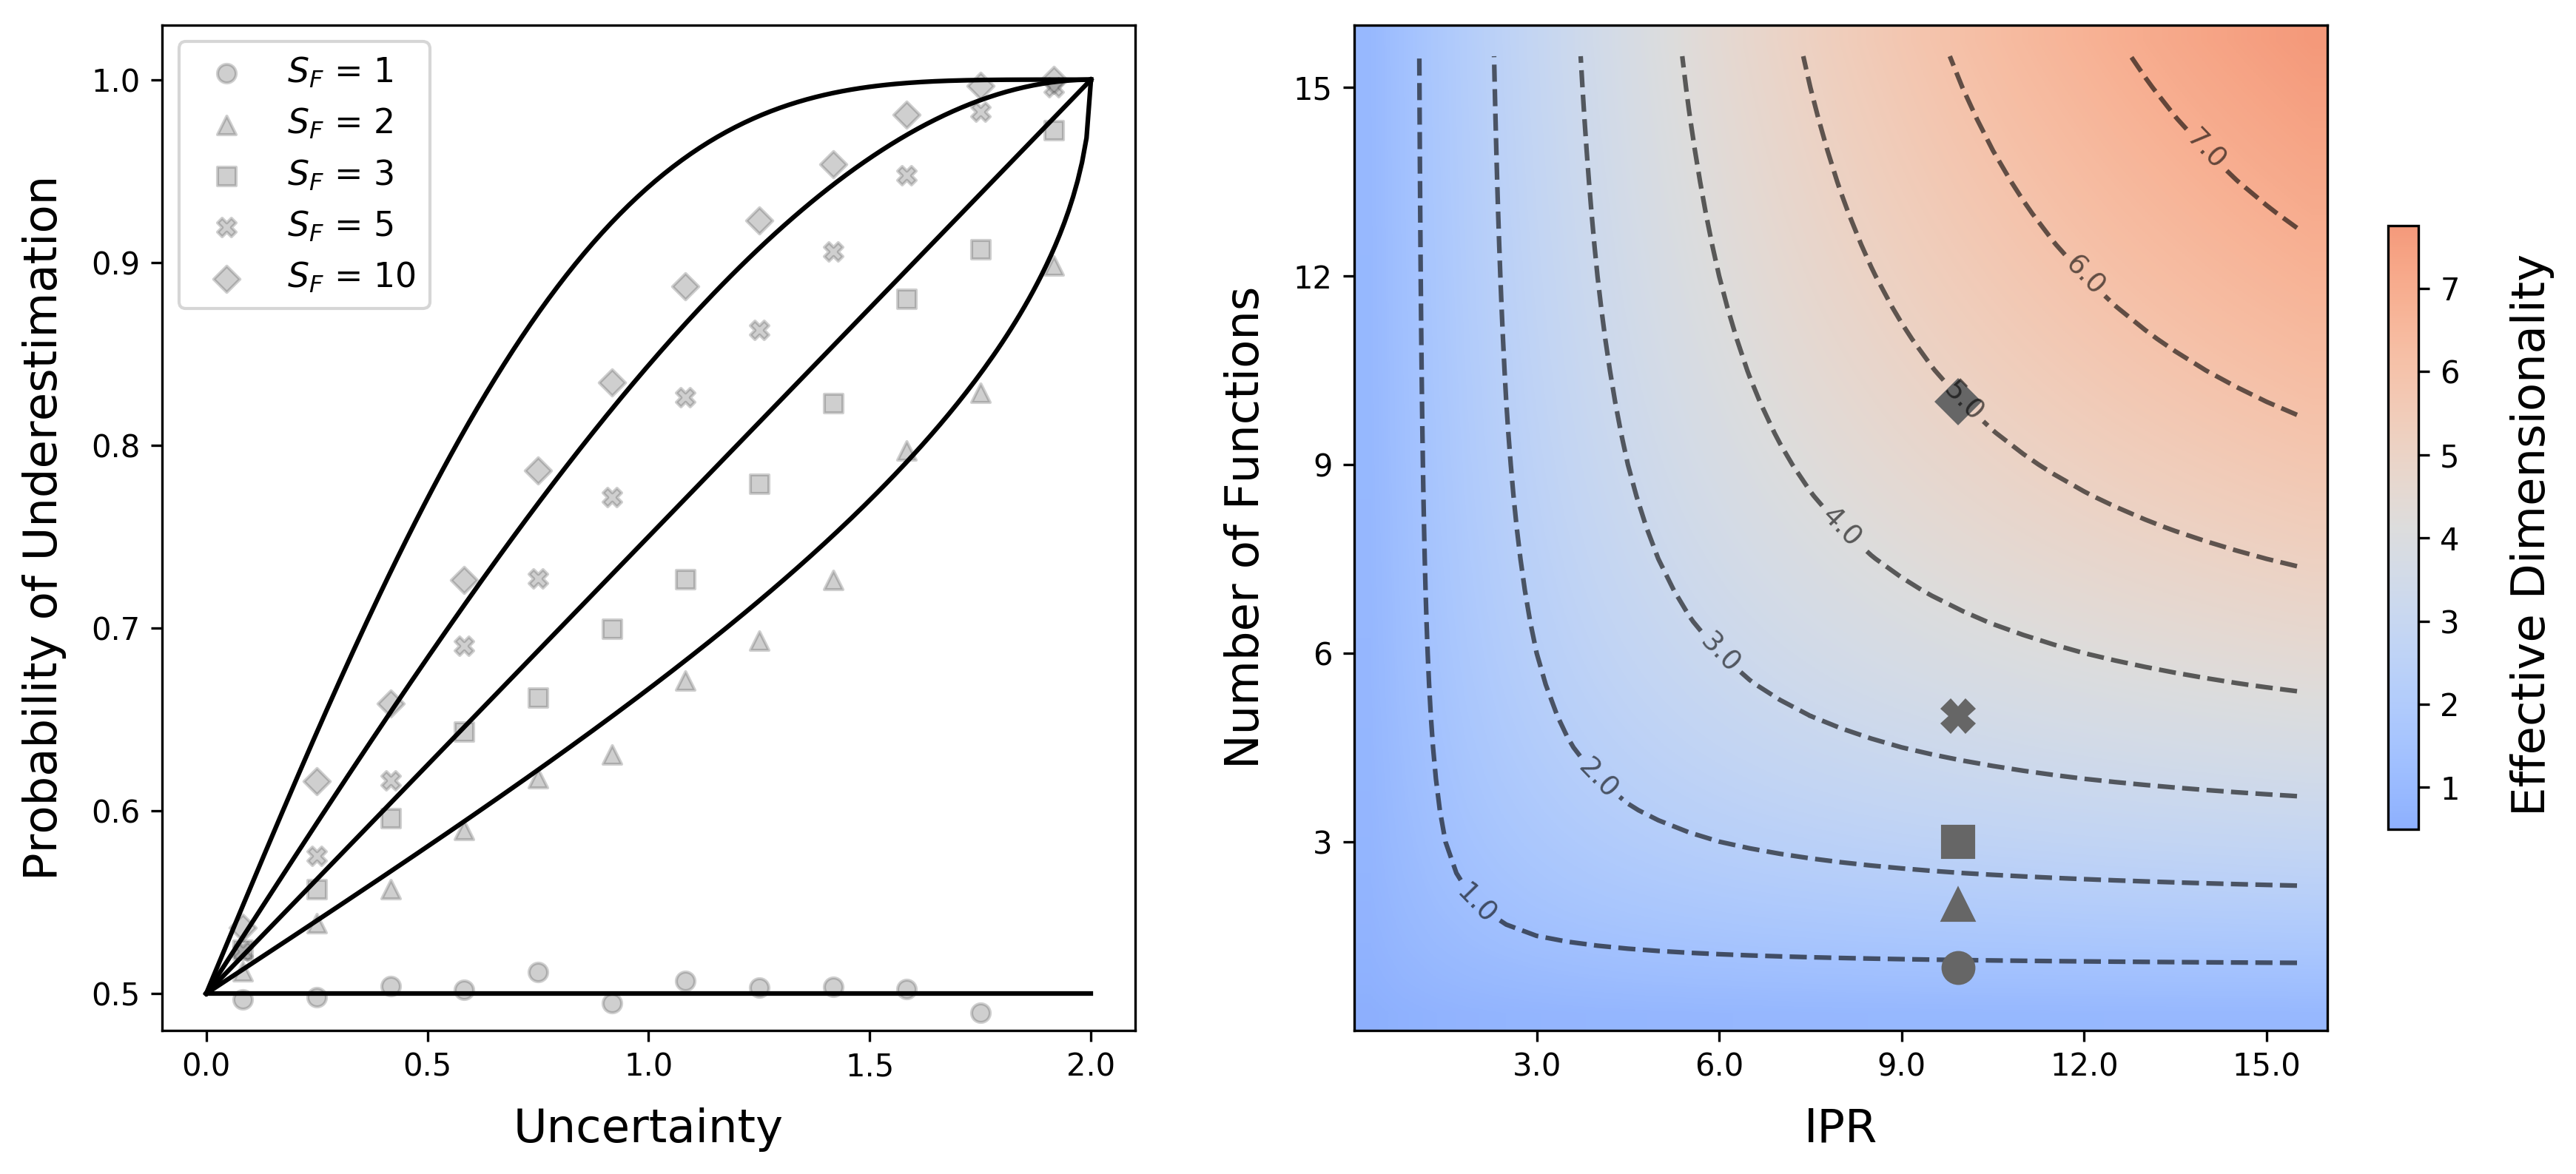

In [21]:
######## Prep ########
S=20
biomass_1 = np.logspace(0, .8, S)         
norm_Bio_1 = biomass_1/norm(biomass_1)
ipr1 = 1/sum(norm_Bio_1**4)



plt.figure(num=None, figsize=(14, 6), dpi=300, facecolor='w', edgecolor='k')


######### Setting up the sub plots using gridspec ############
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.25])



########## Probability of Underestimation ############
plt.subplot(gs[0])

X = np.linspace(0, 2, 200)
plt.plot([0, 2], [0.50, 0.50], color=(0, 0, 0))
plt.plot(X, 1.-0.5*betainc((2-1.)/2., 0.5, 1.-(X**2)/4), color=(0, 0, 0))
plt.plot(X, 1.-0.5*betainc((3-1.)/2., 0.5, 1.-(X**2)/4), color=(0, 0, 0))
plt.plot(X, 1.-0.5*betainc((5-1.)/2., 0.5, 1.-(X**2)/4), color=(0, 0, 0))
plt.plot(X, 1.-0.5*betainc((10-1.)/2., 0.5, 1.-(X**2)/4), color=(0, 0, 0))

plt.xlim(-0.1, 2.1)
plt.ylim(0.48, 1.03)
plt.xlabel("Uncertainty", fontsize=15, labelpad=8)
plt.ylabel("Probability of Underestimation", fontsize=15, labelpad=8)
plt.xticks([0.0, 0.5, 1.0, 1.5, 2.0])

plt.scatter(bin_F1_x, bin_F1_py, color=(0.25, 0.25, 0.25), alpha=0.25, marker = "o", label="$S_{F}$ = 1")
plt.scatter(bin_F2_x, bin_F2_py, color=(0.25, 0.25, 0.25), alpha=0.25, marker = "^", label="$S_{F}$ = 2")
plt.scatter(bin_F3_x, bin_F3_py, color=(0.25, 0.25, 0.25), alpha=0.25, marker = "s", label="$S_{F}$ = 3")
plt.scatter(bin_F5_x, bin_F5_py, color=(0.25, 0.25, 0.25), alpha=0.25, marker = "X", label="$S_{F}$ = 5")
plt.scatter(bin_F10_x, bin_F10_py, color=(0.25, 0.25, 0.25), alpha=0.25, marker = "D", label="$S_{F}$ = 10")

plt.legend(fontsize=11, loc="upper left")


########## Heatmap of Dimensional Interaction ############
plt.subplot(gs[1])
# Setting up input values
x = np.arange(1.0, 16., 0.5)
y = np.arange(1.0, 16., 0.5)
X, Y = np.meshgrid(x, y)
Y = np.flip(Y)
dim = eff_d(X, Y)

# Setting new color map (middle part of coolwarm)
coolwarm = cm.get_cmap('coolwarm', 512)
newcmp = ListedColormap(coolwarm(np.linspace(0.25, 0.75, 256)))

image = plt.imshow(dim, cmap=newcmp, extent=(0, 16, 0, 16), interpolation='bilinear', aspect='auto') # 'nearest')
plt.colorbar(image, label="", shrink = 0.6)

plt.xlabel("IPR", fontsize=15, labelpad = 8)
plt.ylabel("Number of Functions", fontsize=15, labelpad=8)
plt.yticks([3, 6, 9, 12, 15])
plt.xticks([3, 6, 9, 12, 15], ('3.0', '6.0', '9.0', '12.0', '15.0'))

con = plt.contour(X, Y, dim, colors='black', linestyles='dashed', alpha = 0.6)
plt.clabel(con, inline=True, fontsize=9, fmt = '%1.1f');

plt.plot(ipr1, 1, color=(0.4, 0.4, 0.4), marker = "o", markersize=10, alpha=1)
plt.plot(ipr1, 2, color=(0.4, 0.4, 0.4), marker = "^", markersize=10, alpha=1)
plt.plot(ipr1, 3, color=(0.4, 0.4, 0.4), marker = "s", markersize=10, alpha=1)
plt.plot(ipr1, 5, color=(0.4, 0.4, 0.4), marker = "X", markersize=10, alpha=1)
plt.plot(ipr1, 10, color=(0.4, 0.4, 0.4), marker = "D", markersize=10, alpha=1)

plt.text(19, 11.8, "Effective Dimensionality", fontsize=15, rotation=90);

plt.subplots_adjust(wspace=0.2);



[Top](#8)